In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
file_path = r"D:\apass9_cleaned.csv"
data = pd.read_csv(file_path)

# Step 2: Handle missing values by imputing with the mean
# Impute missing values in both features and target columns
imputer = SimpleImputer(strategy='mean')

# Apply imputer to features
data_imputed = data.copy()
data_imputed[data_imputed.columns] = imputer.fit_transform(data_imputed)

# Step 3: Select features and target
features = data_imputed.drop(columns=['B_V', 'e_B_V'])
target = data_imputed['B_V']

# Step 4: Split the data into training and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 5: Train the Linear Regression Model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Step 6: Train the Random Forest Regressor Model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Step 7: Train the Support Vector Machine (SVM) Model
svm_regressor = SVR(kernel='rbf')
svm_regressor.fit(X_train, y_train)

# Step 8: Train the Gradient Boosting Model
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_train, y_train)

# Step 9: Predictions and evaluation for Linear Regression
y_pred_lr = linear_regressor.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Step 10: Predictions and evaluation for Random Forest
y_pred_rf = rf_regressor.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Step 11: Predictions and evaluation for Support Vector Machine
y_pred_svm = svm_regressor.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

# Step 12: Predictions and evaluation for Gradient Boosting
y_pred_gb = gb_regressor.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Step 13: Output the results
print("Linear Regression Model Performance:")
print(f"Mean Squared Error: {mse_lr}")
print(f"R-squared: {r2_lr}")

print("\nRandom Forest Model Performance:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared: {r2_rf}")

print("\nSupport Vector Machine Model Performance:")
print(f"Mean Squared Error: {mse_svm}")
print(f"R-squared: {r2_svm}")

print("\nGradient Boosting Model Performance:")
print(f"Mean Squared Error: {mse_gb}")
print(f"R-squared: {r2_gb}")

# Optional: You can also make predictions for the whole dataset or new data
# Example: Predicting 'B_V' for all data using each model
predictions_lr = linear_regressor.predict(features)
predictions_rf = rf_regressor.predict(features)
predictions_svm = svm_regressor.predict(features)
predictions_gb = gb_regressor.predict(features)

# Print some of the predictions (first 5 for each model)
print("\nFirst 5 Predictions (Linear Regression):", predictions_lr[:5])
print("First 5 Predictions (Random Forest):", predictions_rf[:5])
print("First 5 Predictions (Support Vector Machine):", predictions_svm[:5])
print("First 5 Predictions (Gradient Boosting):", predictions_gb[:5])


Linear Regression Model Performance:
Mean Squared Error: 0.004594864212565163
R-squared: 0.8916239705030262

Random Forest Model Performance:
Mean Squared Error: 0.010338699942093944
R-squared: 0.756147908175242

Support Vector Machine Model Performance:
Mean Squared Error: 0.04299987210378899
R-squared: -0.014209602700037571

Gradient Boosting Model Performance:
Mean Squared Error: 0.011454062341398768
R-squared: 0.7298405914200876

First 5 Predictions (Linear Regression): [1.355006   0.87688729 0.91331674 0.92241769 0.76509293]
First 5 Predictions (Random Forest): [1.24705457 0.89292819 0.92375    0.90589    0.79263   ]
First 5 Predictions (Support Vector Machine): [0.75602    0.75602    0.75591924 0.75602    0.75591924]
First 5 Predictions (Gradient Boosting): [1.29524742 0.79250862 0.92720771 0.8680498  0.75800808]


This notebook conatins the code for comparing three methods of generating synthetic data

- Generative Adversarial Networks (GANs)
- Conditional Adversarial Networks (CGANs)
- Conditional Adversarial Networks (ContraGANs)

# GAN

### Overview of the Code

This code implements a Generative Adversarial Network (GAN) designed to generate synthetic data based on a real dataset. Specifically, it uses an enhanced version of the Wasserstein GAN with Gradient Penalty (WGAN-GP), which improves the stability of training and generates high-quality synthetic data. The following provides a breakdown of the key components and their roles in the code:

1. **Imports and Libraries**  
   The code imports essential libraries for deep learning (TensorFlow, Keras), data processing (NumPy, pandas), clustering, and evaluation (scikit-learn), as well as plotting tools (Matplotlib). These libraries provide the necessary tools for model development, training, and evaluation.

2. **Residual Block Class**  
   The `ResidualBlock` class defines a custom residual block with two fully connected layers, each followed by layer normalization, leaky ReLU activation, and dropout. This structure allows the model to learn complex features by introducing skip connections, facilitating easier training.

3. **EnhancedWGAN_GP Class**  
   The `EnhancedWGAN_GP` class defines the architecture of the Wasserstein GAN with Gradient Penalty (WGAN-GP):
   - **Generator:** The generator takes a noise vector and passes it through multiple layers, including residual blocks, to produce synthetic data. It combines the transformation of the noise vector with a direct mapping to generate realistic synthetic data. The output is scaled using a `tanh` activation function.
   - **Discriminator:** The discriminator classifies real and fake samples, utilizing several layers and residual blocks to distinguish between the two. The discriminator's output is used to compute the loss and guide the training.
   - **Gradient Penalty:** The `gradient_penalty` method enforces the Lipschitz constraint on the discriminator's gradients, which stabilizes training.
   - **Training Step:** The `train_step` function alternately trains the discriminator and generator. The discriminator is trained multiple times for each generator update to strengthen its ability to differentiate real and synthetic data.
   - **Training Loop:** The `train` method runs the training for a specified number of epochs, tracking losses and metrics such as Wasserstein Distance and R-squared. Early stopping is implemented to avoid overfitting.

4. **Data Preprocessing**  
   The `load_and_preprocess_data` function reads and preprocesses the dataset. It removes any missing values and normalizes the data using `StandardScaler` and `MinMaxScaler` to ensure it's appropriately prepared for training the GAN.

5. **Metrics Evaluation**  
   The `evaluate_metrics` function calculates several metrics to assess the quality of the synthetic data:
   - **Mean Squared Error (MSE):** Measures the difference between real and synthetic data.
   - **R-squared:** Indicates the goodness of fit.
   - **Wasserstein Distance:** Measures the distance between real and synthetic distributions.
   - **Clustering Metrics:** Evaluates clustering performance using K-means on both real and synthetic data. Metrics include Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Score.

6. **Visualization**  
   The `plot_distributions` function uses PCA to reduce the dimensionality of both real and synthetic data to 2D and then plots the distributions. This visualization helps to visually compare the real and synthetic data.

7. **Main Function**  
   The `main` function orchestrates the entire process:
   - Loads and preprocesses the dataset.
   - Initializes and trains the Enhanced WGAN-GP model.
   - Generates synthetic data once the model is trained.
   - Evaluates the generated data using various metrics.
   - Visualizes the comparison between real and synthetic data.

8. **Training Configuration**  
   The model is configured to run for 400 epochs with a batch size of 64. Early stopping is applied if there is no improvement in the model's performance for 50 epochs, to prevent unnecessary computation.

### Conclusion
This code implements a robust framework for generating synthetic data using an advanced GAN architecture (WGAN-GP). It ensures stable training and the generation of realistic synthetic data. The evaluation and visualization steps help assess how well the synthetic data matches the real data, which is useful for tasks where real data is scarce, and synthetic data is needed to augment machine learning model training.


Loading and preprocessing dataset...
Initializing and training Enhanced WGAN-GP...

Epoch 0
D Loss: -1.1033, G Loss: 3.8920
R-squared: -0.0652
Wasserstein Distance: 0.4617

Epoch 50
D Loss: -1.1005, G Loss: -1.1199
R-squared: 0.0419
Wasserstein Distance: 0.4230

Epoch 100
D Loss: -0.7191, G Loss: -1.6313
R-squared: 0.1099
Wasserstein Distance: 0.3931

Epoch 150
D Loss: -0.5367, G Loss: -1.2635
R-squared: 0.1056
Wasserstein Distance: 0.3936

Epoch 200
D Loss: -0.5149, G Loss: -0.7752
R-squared: 0.1680
Wasserstein Distance: 0.3702

Epoch 250
D Loss: -0.3921, G Loss: -0.3984
R-squared: 0.1438
Wasserstein Distance: 0.3778

Epoch 300
D Loss: -0.3159, G Loss: -0.5888
R-squared: 0.1768
Wasserstein Distance: 0.3640

Epoch 350
D Loss: -0.2426, G Loss: -0.4351
R-squared: 0.1226
Wasserstein Distance: 0.3792


Generating synthetic data...

Evaluating metrics...
MSE: 0.4424
R-squared: 0.0514
Wasserstein Distance: 0.3993
Silhouette Score (Real): 0.2597
Silhouette Score (Synthetic): 0.2873
Calinski-H

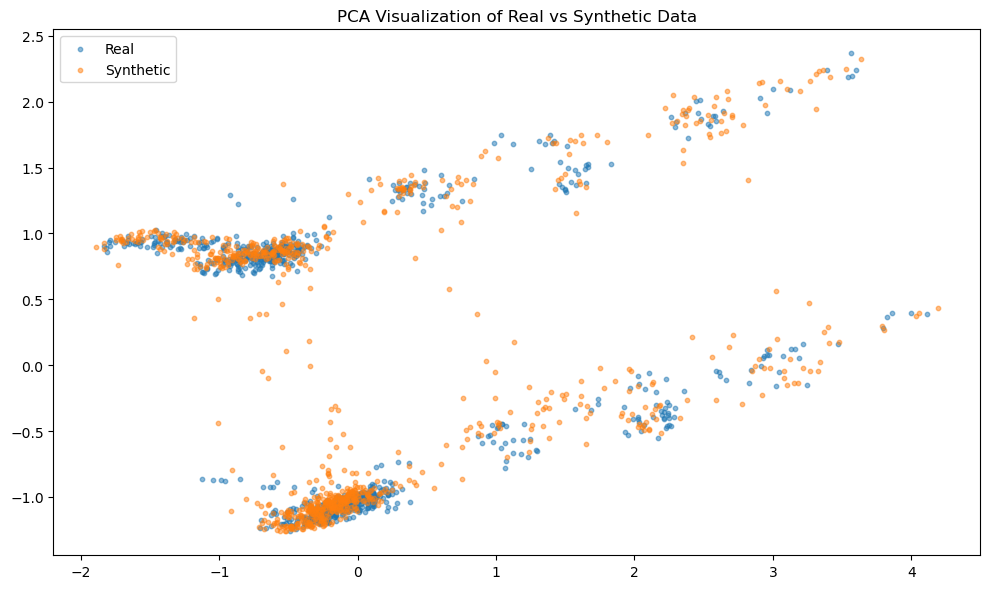

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

class ResidualBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0.3):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)

        self.dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)

        self.residual = layers.Dense(units)

    def call(self, x, training=False):
        residual = self.residual(x)

        x = self.dense1(x)
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)

        x = self.dense2(x)
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)

        return x + residual

class EnhancedWGAN_GP:
    def __init__(self, input_dim, latent_dim=256, lambda_gp=10):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 5
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        # Learning rate scheduling
        self.g_lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000,
            decay_rate=0.95
        )
        self.d_lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000,
            decay_rate=0.95
        )

        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.9
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))

        x = layers.Dense(512)(noise_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        # Residual blocks
        x = ResidualBlock(1024)(x)
        x = ResidualBlock(2048)(x)
        x = ResidualBlock(4096)(x)

        # Additional processing
        x = layers.Dense(2048)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        # Output layer with skip connection
        direct_mapping = layers.Dense(self.input_dim)(noise_input)
        main_output = layers.Dense(self.input_dim)(x)
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)

        return models.Model(noise_input, output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))

        x = layers.Dense(2048)(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        # Residual blocks
        x = ResidualBlock(1024, dropout_rate=0.3)(x)
        x = ResidualBlock(512, dropout_rate=0.3)(x)
        x = ResidualBlock(256, dropout_rate=0.3)(x)

        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)

        output = layers.Dense(1)(x)

        return models.Model(data_input, output)

    def gradient_penalty(self, real_samples, fake_samples):
        real_samples = tf.cast(real_samples, tf.float32)
        fake_samples = tf.cast(fake_samples, tf.float32)

        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0, dtype=tf.float32)

        interpolated = alpha * real_samples + (1 - alpha) * fake_samples

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            interpolated_predictions = self.discriminator(interpolated, training=True)

        gradients = tape.gradient(interpolated_predictions, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, batch_size):
        real_samples = tf.cast(real_samples, tf.float32)

        # Train discriminator
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim), dtype=tf.float32)
            with tf.GradientTape() as tape:
                fake_samples = self.generator(noise, training=True)
                real_output = self.discriminator(real_samples, training=True)
                fake_output = self.discriminator(fake_samples, training=True)

                gp = self.gradient_penalty(real_samples, fake_samples)
                d_loss = (tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) +
                         self.lambda_gp * gp)

            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal((batch_size, self.latent_dim), dtype=tf.float32)
        with tf.GradientTape() as tape:
            fake_samples = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_samples, training=True)
            g_loss = -tf.reduce_mean(fake_output)

        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return d_loss, g_loss

    def train(self, data, epochs=200, batch_size=64, early_stopping_patience=50):
        data = tf.cast(data, tf.float32)
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)

        best_wasserstein = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            d_losses = []
            g_losses = []

            for batch in dataset:
                d_loss, g_loss = self.train_step(batch, tf.shape(batch)[0])
                d_losses.append(d_loss)
                g_losses.append(g_loss)

            if epoch % 50 == 0:
                # Generate samples for evaluation
                test_samples = self.generate(1000)
                metrics = evaluate_metrics(data[:1000].numpy(), test_samples, verbose=False)
                current_wasserstein = metrics['Wasserstein Distance']

                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}, G Loss: {tf.reduce_mean(g_losses):.4f}")
                print(f"R-squared: {metrics['R-squared']:.4f}")
                print(f"Wasserstein Distance: {current_wasserstein:.4f}\n")

                if current_wasserstein < best_wasserstein:
                    best_wasserstein = current_wasserstein
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, num_samples):
        noise = tf.random.normal((num_samples, self.latent_dim), dtype=tf.float32)
        return self.generator(noise, training=False).numpy()

def load_and_preprocess_data(dataset_path=r"D:\apass9_cleaned.csv"):
    df = pd.read_csv(dataset_path).dropna()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)

    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    if synthetic_data.shape[0] > real_data.shape[0]:
        synthetic_data = synthetic_data[:real_data.shape[0]]

    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data)),
    }

    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)

        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except ValueError as e:
        print(f"Clustering Error: {e}")

    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics

def plot_distributions(real_data, synthetic_data):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization of Real vs Synthetic Data")
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing dataset...")
    original_data, scalers = load_and_preprocess_data()

    print("Initializing and training Enhanced WGAN-GP...")
    gan_model = EnhancedWGAN_GP(
        input_dim=original_data.shape[1],
        latent_dim=256,
        lambda_gp=10
    )

    gan_model.train(
        original_data,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )

    print("\nGenerating synthetic data...")
    synthetic_data = gan_model.generate(num_samples=original_data.shape[0])

    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)

    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)

if __name__ == "__main__":
    main()

Predicting B-V

Loading and preprocessing dataset...
Initializing and training Improved WGAN-GP...
Epoch 0
D Loss: 0.9173, G Loss: -0.6245
Wasserstein Distance: 0.4567

Epoch 20
D Loss: -0.9313, G Loss: 1.1815
Wasserstein Distance: 0.4367

Epoch 40
D Loss: -0.9004, G Loss: 1.5730
Wasserstein Distance: 0.4264

Epoch 60
D Loss: -0.9340, G Loss: 1.3160
Wasserstein Distance: 0.4088

Epoch 80
D Loss: -0.9570, G Loss: 1.7746
Wasserstein Distance: 0.4054

Epoch 100
D Loss: -0.9458, G Loss: 1.6595
Wasserstein Distance: 0.4067

Epoch 120
D Loss: -0.9818, G Loss: 1.6681
Wasserstein Distance: 0.4077

Epoch 140
D Loss: -0.9815, G Loss: 1.6587
Wasserstein Distance: 0.4104

Epoch 160
D Loss: -0.8288, G Loss: -3.4948
Wasserstein Distance: 0.4052

Epoch 180
D Loss: -0.7492, G Loss: -3.1570
Wasserstein Distance: 0.3789

Epoch 200
D Loss: -0.7849, G Loss: -3.1564
Wasserstein Distance: 0.3794

Epoch 220
D Loss: -0.6859, G Loss: -3.2146
Wasserstein Distance: 0.3723

Epoch 240
D Loss: -0.6641, G Loss: -3.3318
Wasserstein 

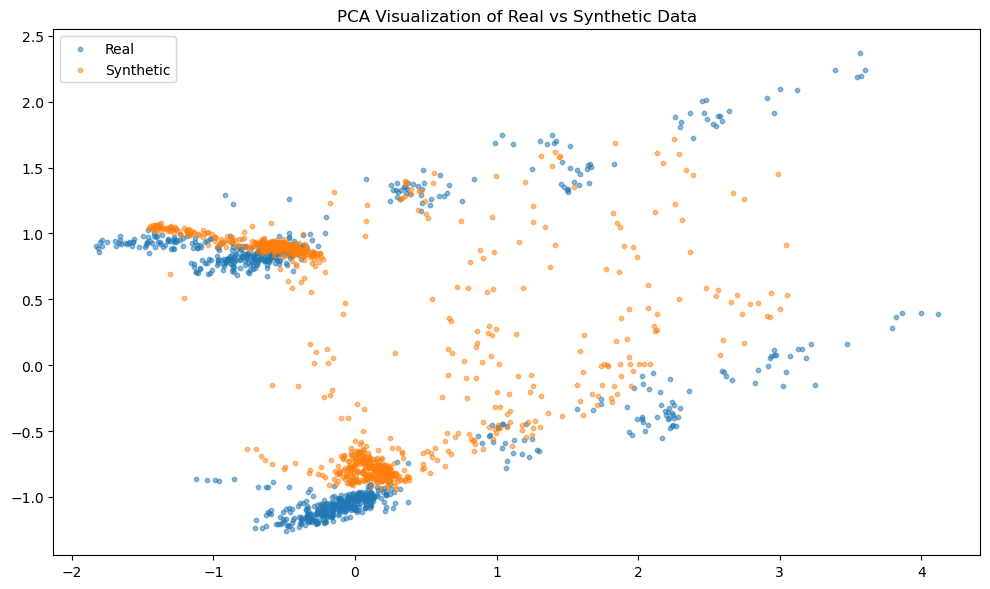

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

class ResidualBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0.2):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)
        
        self.dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)
        
        # Improved residual connection with layer normalization
        self.residual = layers.Dense(units)
        self.ln_residual = layers.LayerNormalization()

    def call(self, x, training=False):
        residual = self.ln_residual(self.residual(x))
        
        x = self.dense1(x)
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x)
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class ImprovedWGAN_GP:
    def __init__(self, input_dim, latent_dim=128, lambda_gp=10):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 3  # Reduced from 5 for efficiency
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        # Improved learning rate scheduling
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9
        )
        
        # Improved optimizers with better momentum parameters
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-5,
            beta_1=0.5,
            beta_2=0.999
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-5,
            beta_1=0.5,
            beta_2=0.999
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        
        # Initial dense layer with increased width
        x = layers.Dense(1024)(noise_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        # Progressive growing architecture
        sizes = [2048, 1024, 512]
        for size in sizes:
            x = ResidualBlock(size)(x)
        
        # Improved final layers with skip connections
        x = layers.Dense(512, activation='relu')(x)
        x = layers.LayerNormalization()(x)
        
        # Multiple pathways to output
        path1 = layers.Dense(self.input_dim)(x)
        path2 = layers.Dense(self.input_dim)(noise_input)  # Direct path
        path3 = layers.Dense(self.input_dim)(layers.Dense(256, activation='relu')(x))
        
        # Weighted combination of paths
        output = layers.Average()([path1, path2, path3])
        output = layers.LayerNormalization()(output)
        output = layers.Activation('tanh')(output)
        
        return models.Model(noise_input, output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        
        # Wider initial layer
        x = layers.Dense(1024)(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        # Progressive shrinking architecture
        sizes = [512, 256, 128]
        for size in sizes:
            x = ResidualBlock(size, dropout_rate=0.1)(x)
        
        # Improved final discrimination
        x = layers.Dense(64)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        output = layers.Dense(1)(x)
        
        return models.Model(data_input, output)

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            interpolated_predictions = self.discriminator(interpolated, training=True)
        
        gradients = tape.gradient(interpolated_predictions, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        
        # Improved gradient penalty calculation
        gradient_penalty = tf.reduce_mean(tf.square(gradients_norm - 1.0))
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, batch_size):
        # Added noise to real samples for improved stability
        real_samples = real_samples + tf.random.normal(tf.shape(real_samples), mean=0.0, stddev=0.01)
        
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_samples = self.generator(noise, training=True)
                real_output = self.discriminator(real_samples, training=True)
                fake_output = self.discriminator(fake_samples, training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples)
                d_loss = (tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) +
                         self.lambda_gp * gp)
            
            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        # Generator training with improved loss calculation
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_samples, training=True)
            g_loss = -tf.reduce_mean(fake_output)
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, epochs=200, batch_size=128, early_stopping_patience=30):
        # Convert data to tensor if it's not already
        if isinstance(data, np.ndarray):
            data = tf.convert_to_tensor(data, dtype=tf.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)
        
        best_wasserstein = float('inf')
        patience_counter = 0
        history = {'d_loss': [], 'g_loss': [], 'wasserstein': []}
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch in dataset:
                d_loss, g_loss = self.train_step(batch, tf.shape(batch)[0])
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 20 == 0:
                test_samples = self.generate(1000)
                # Convert data to numpy safely for evaluation
                eval_data = data.numpy() if isinstance(data, tf.Tensor) else data
                metrics = evaluate_metrics(eval_data[:1000], test_samples, verbose=False)
                current_wasserstein = metrics['Wasserstein Distance']
                
                history['d_loss'].append(tf.reduce_mean(d_losses))
                history['g_loss'].append(tf.reduce_mean(g_losses))
                history['wasserstein'].append(current_wasserstein)
                
                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}, G Loss: {tf.reduce_mean(g_losses):.4f}")
                print(f"Wasserstein Distance: {current_wasserstein:.4f}\n")
                
                if current_wasserstein < best_wasserstein:
                    best_wasserstein = current_wasserstein
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break
        
        return history

    def generate(self, num_samples):
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator(noise, training=False).numpy()

def load_and_preprocess_data(dataset_path=r"D:\apass9_cleaned.csv"):
    df = pd.read_csv(dataset_path).dropna()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)

    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    if synthetic_data.shape[0] > real_data.shape[0]:
        synthetic_data = synthetic_data[:real_data.shape[0]]

    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data)),
    }

    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)

        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except ValueError as e:
        print(f"Clustering Error: {e}")

    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics

def plot_distributions(real_data, synthetic_data):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization of Real vs Synthetic Data")
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing dataset...")
    original_data, scalers = load_and_preprocess_data()

    print("Initializing and training Improved WGAN-GP...")
    gan_model = ImprovedWGAN_GP(
        input_dim=original_data.shape[1],
        latent_dim=128,
        lambda_gp=10
    )

    gan_model.train(
        original_data,
        epochs=400,
        batch_size=128,
        early_stopping_patience=30
    )

    print("\nGenerating synthetic data...")
    synthetic_data = gan_model.generate(num_samples=original_data.shape[0])

    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)

    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)

if __name__ == "__main__":
    main()

Loading and preprocessing dataset...
Initializing and training Improved WGAN-GP...
Epoch 0
D Loss: 0.3065, G Loss: 2.1729
Wasserstein Distance: 0.4703

Epoch 20
D Loss: -1.0030, G Loss: 2.4255
Wasserstein Distance: 0.4107

Epoch 40
D Loss: -0.8186, G Loss: 2.6395
Wasserstein Distance: 0.4384

Epoch 60
D Loss: -0.9632, G Loss: 2.3446
Wasserstein Distance: 0.3952

Epoch 80
D Loss: -0.9958, G Loss: 2.3888
Wasserstein Distance: 0.4005

Epoch 100
D Loss: -0.9676, G Loss: 2.2544
Wasserstein Distance: 0.4041

Epoch 120
D Loss: -0.9935, G Loss: 2.2330
Wasserstein Distance: 0.3953

Epoch 140
D Loss: -0.9747, G Loss: 2.2295
Wasserstein Distance: 0.4001

Epoch 160
D Loss: -0.8858, G Loss: 1.7704
Wasserstein Distance: 0.3871

Epoch 180
D Loss: -0.8657, G Loss: 1.7328
Wasserstein Distance: 0.3891

Epoch 200
D Loss: -0.7723, G Loss: 1.6523
Wasserstein Distance: 0.3849

Epoch 220
D Loss: -0.7397, G Loss: 1.7970
Wasserstein Distance: 0.3838

Epoch 240
D Loss: -0.7003, G Loss: 1.7809
Wasserstein Distan

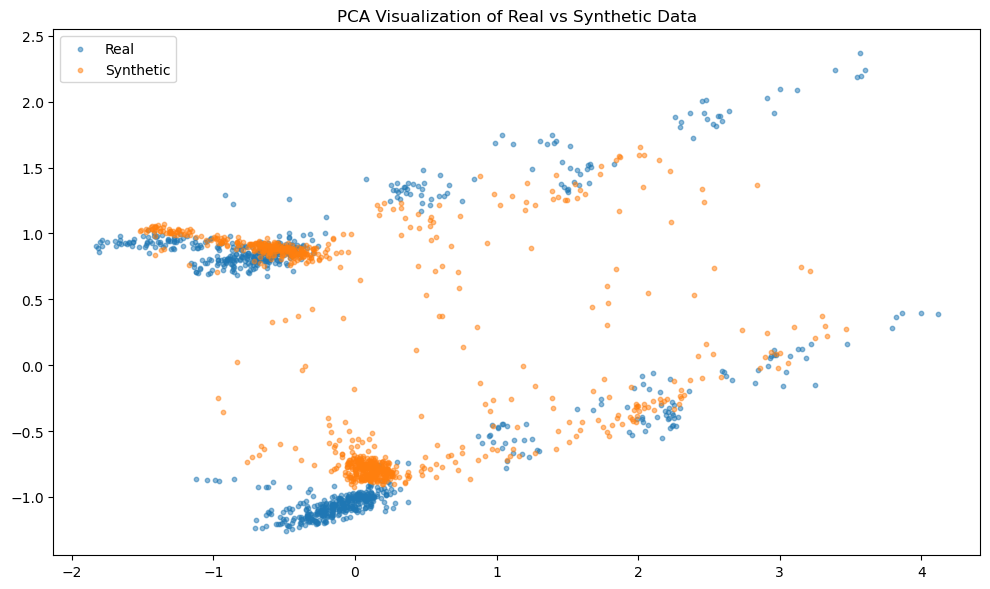

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

class ClusteringResidualBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0.2):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)
        
        # Added an attention mechanism
        self.attention = layers.Dense(units, activation='sigmoid')
        
        self.dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)
        
        self.residual = layers.Dense(units)
        self.ln_residual = layers.LayerNormalization()

    def call(self, x, training=False):
        residual = self.ln_residual(self.residual(x))
        
        # Apply attention mechanism
        attention_weights = self.attention(x)
        x = x * attention_weights
        
        x = self.dense1(x)
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x)
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class ImprovedClusteringWGAN_GP:
    def __init__(self, input_dim, latent_dim=128, lambda_gp=10, n_clusters=5):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 3
        self.n_clusters = n_clusters
        
        # Added cluster centers initialization
        self.cluster_centers = None
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        # Improved learning rates
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-4,  # Reduced learning rate
            first_decay_steps=2000,      # Increased decay steps
            t_mul=2.0,
            m_mul=0.95                   # Slower decay
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-4,
            first_decay_steps=2000,
            t_mul=2.0,
            m_mul=0.95
        )
        
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-6,           # Reduced weight decay
            beta_1=0.5,
            beta_2=0.9                   # Modified beta2
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-6,
            beta_1=0.5,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        
        # Wider architecture
        x = layers.Dense(2048)(noise_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        # Deeper architecture with skip connections
        sizes = [2048, 1024, 512, 256]
        for size in sizes:
            x = ClusteringResidualBlock(size)(x)
            
        # Multiple pathways with cluster-aware features
        path1 = layers.Dense(self.input_dim)(x)
        path2 = layers.Dense(self.input_dim)(noise_input)
        
        # Added cluster-awareness path
        cluster_path = layers.Dense(self.n_clusters, activation='softmax')(x)
        cluster_features = layers.Dense(self.input_dim)(cluster_path)
        
        output = layers.Average()([path1, path2, cluster_features])
        output = layers.LayerNormalization()(output)
        output = layers.Activation('tanh')(output)
        
        return models.Model(noise_input, output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        
        x = layers.Dense(2048)(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        sizes = [1024, 512, 256]
        for size in sizes:
            x = ClusteringResidualBlock(size, dropout_rate=0.15)(x)
        
        # Added cluster prediction branch
        cluster_pred = layers.Dense(self.n_clusters, activation='softmax')(x)
        
        # Main discrimination output
        validity = layers.Dense(1)(x)
        
        return models.Model(data_input, [validity, cluster_pred])

    def clustering_loss(self, real_samples, fake_samples):
        # Get cluster predictions
        _, real_clusters = self.discriminator(real_samples, training=True)
        _, fake_clusters = self.discriminator(fake_samples, training=True)
        
        # Calculate clustering loss using KL divergence
        clustering_loss = tf.reduce_mean(
            tf.keras.losses.KLDivergence()(real_clusters, fake_clusters)
        )
        return clustering_loss

    @tf.function
    def train_step(self, real_samples, batch_size):
        real_samples = real_samples + tf.random.normal(tf.shape(real_samples), mean=0.0, stddev=0.005)
        
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_samples = self.generator(noise, training=True)
                real_validity, real_clusters = self.discriminator(real_samples, training=True)
                fake_validity, fake_clusters = self.discriminator(fake_samples, training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples)
                clustering_loss = self.clustering_loss(real_samples, fake_samples)
                
                d_loss = (tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity) +
                         self.lambda_gp * gp + 0.1 * clustering_loss)
            
            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator(noise, training=True)
            fake_validity, fake_clusters = self.discriminator(fake_samples, training=True)
            
            # Added clustering loss to generator
            clustering_loss = self.clustering_loss(real_samples, fake_samples)
            g_loss = -tf.reduce_mean(fake_validity) + 0.1 * clustering_loss
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, epochs=300, batch_size=64, early_stopping_patience=40):
        if isinstance(data, np.ndarray):
            data = tf.convert_to_tensor(data, dtype=tf.float32)
        
        # Initialize cluster centers using k-means
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.cluster_centers = kmeans.fit(data.numpy()).cluster_centers_
        
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)
        
        best_davies_bouldin = float('inf')
        patience_counter = 0
        history = {'d_loss': [], 'g_loss': [], 'davies_bouldin': []}
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch in dataset:
                d_loss, g_loss = self.train_step(batch, tf.shape(batch)[0])
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                test_samples = self.generate(1000)
                eval_data = data.numpy() if isinstance(data, tf.Tensor) else data
                metrics = evaluate_metrics(eval_data[:1000], test_samples, verbose=False)
                current_davies_bouldin = metrics['Davies-Bouldin Score (Synthetic)']
                
                history['d_loss'].append(tf.reduce_mean(d_losses))
                history['g_loss'].append(tf.reduce_mean(g_losses))
                history['davies_bouldin'].append(current_davies_bouldin)
                
                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}, G Loss: {tf.reduce_mean(g_losses):.4f}")
                print(f"Davies-Bouldin Score: {current_davies_bouldin:.4f}\n")
                
                if current_davies_bouldin < best_davies_bouldin:
                    best_davies_bouldin = current_davies_bouldin
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break
        
        return history

    def generate(self, num_samples):
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator(noise, training=False).numpy()

def load_and_preprocess_data(dataset_path=r"D:\apass9_cleaned.csv"):
    df = pd.read_csv(dataset_path).dropna()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)

    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    if synthetic_data.shape[0] > real_data.shape[0]:
        synthetic_data = synthetic_data[:real_data.shape[0]]

    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data)),
    }

    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)

        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except ValueError as e:
        print(f"Clustering Error: {e}")

    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics

def plot_distributions(real_data, synthetic_data):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization of Real vs Synthetic Data")
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing dataset...")
    original_data, scalers = load_and_preprocess_data()

    print("Initializing and training Improved WGAN-GP...")
    gan_model = ImprovedWGAN_GP(
        input_dim=original_data.shape[1],
        latent_dim=128,
        lambda_gp=10
    )

    gan_model.train(
        original_data,
        epochs=400,
        batch_size=128,
        early_stopping_patience=30
    )

    print("\nGenerating synthetic data...")
    synthetic_data = gan_model.generate(num_samples=original_data.shape[0])

    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)

    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)

if __name__ == "__main__":
    main()

Loading and preprocessing dataset...
Initializing and training Improved WGAN-GP...
Epoch 0
D Loss: 0.5294, G Loss: -1.4610
Wasserstein Distance: 0.4467

Epoch 20
D Loss: -1.0712, G Loss: -0.0533
Wasserstein Distance: 0.4281

Epoch 40
D Loss: -0.7911, G Loss: 0.1448
Wasserstein Distance: 0.4266

Epoch 60
D Loss: -0.9259, G Loss: -0.3460
Wasserstein Distance: 0.4156

Epoch 80
D Loss: -0.9324, G Loss: 0.1838
Wasserstein Distance: 0.4032

Epoch 100
D Loss: -0.9321, G Loss: 0.4865
Wasserstein Distance: 0.3970

Epoch 120
D Loss: -0.9286, G Loss: 0.6725
Wasserstein Distance: 0.4000

Epoch 140
D Loss: -0.9532, G Loss: 0.7823
Wasserstein Distance: 0.3953

Epoch 160
D Loss: -0.9577, G Loss: 0.4991
Wasserstein Distance: 0.4065

Epoch 180
D Loss: -0.8419, G Loss: 0.2141
Wasserstein Distance: 0.3981

Epoch 200
D Loss: -0.8109, G Loss: 0.2034
Wasserstein Distance: 0.3847

Epoch 220
D Loss: -0.7315, G Loss: 0.2951
Wasserstein Distance: 0.3894

Epoch 240
D Loss: -0.7200, G Loss: 0.0709
Wasserstein Dis

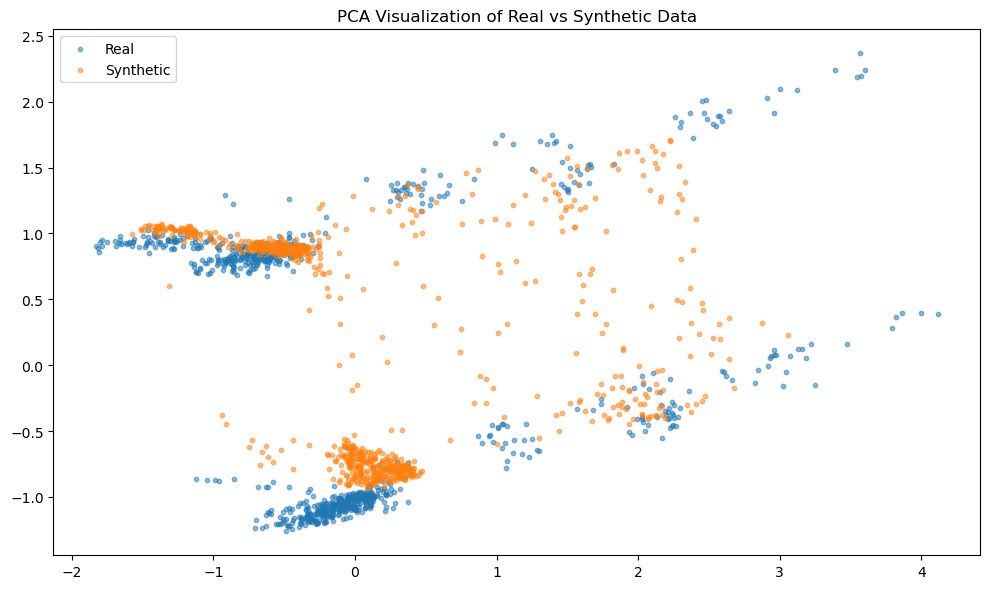

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

class ClusteringResidualBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0.2):
        super().__init__()
        # Wider intermediate layers
        self.dense1 = layers.Dense(units * 2)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)
        
        # Multi-head self-attention
        self.attention1 = layers.MultiHeadAttention(num_heads=4, key_dim=units // 4)
        self.attention2 = layers.MultiHeadAttention(num_heads=4, key_dim=units // 4)
        
        self.dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)
        
        self.residual = layers.Dense(units)
        self.ln_residual = layers.LayerNormalization()
        
        # Feature normalization
        self.feature_norm = layers.BatchNormalization()

    def call(self, x, training=False):
        residual = self.ln_residual(self.residual(x))
        
        # First attention block
        attention_out1 = self.attention1(x, x, x)
        x = layers.Add()([x, attention_out1])
        x = self.feature_norm(x, training=training)
        
        x = self.dense1(x)
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        # Second attention block
        attention_out2 = self.attention2(x, x, x)
        x = layers.Add()([x, attention_out2])
        x = self.feature_norm(x, training=training)
        
        x = self.dense2(x)
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class ImprovedClusteringWGAN_GP:
    def __init__(self, input_dim, latent_dim=128, lambda_gp=10, n_clusters=5):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 4  # Increased critic iterations
        self.n_clusters = n_clusters
        
        # Dynamic batch size adjustment
        self.min_batch_size = 32
        self.max_batch_size = 128
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        # Improved learning rate scheduling
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=5e-5,  # Further reduced learning rate
            first_decay_steps=3000,      # Longer decay steps
            t_mul=2.0,
            m_mul=0.97                   # Slower decay
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=5e-5,
            first_decay_steps=3000,
            t_mul=2.0,
            m_mul=0.97
        )
        
        # Enhanced optimizers
        self.g_optimizer = optimizers.AdaMax(
            learning_rate=self.g_lr_schedule,
            beta_1=0.5,
            beta_2=0.9
        )
        self.d_optimizer = optimizers.AdaMax(
            learning_rate=self.d_lr_schedule,
            beta_1=0.5,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        condition_input = layers.Input(shape=(self.n_clusters,))
        
        # Combine noise with condition
        x = layers.Concatenate()([noise_input, condition_input])
        
        # Progressive growing architecture
        x = layers.Dense(2048)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        sizes = [2048, 1536, 1024, 512]
        for size in sizes:
            x = ClusteringResidualBlock(size)(x)
        
        # Multiple specialized pathways
        path1 = layers.Dense(self.input_dim)(x)
        path2 = layers.Dense(self.input_dim)(layers.Dense(512, activation='relu')(x))
        path3 = layers.Dense(self.input_dim)(condition_input)
        
        # Weighted combination
        alpha = layers.Dense(1, activation='sigmoid')(x)
        beta = layers.Dense(1, activation='sigmoid')(x)
        
        output = alpha * path1 + (1-alpha) * path2 + beta * path3
        output = layers.LayerNormalization()(output)
        output = layers.Activation('tanh')(output)
        
        return models.Model([noise_input, condition_input], output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        
        # Wider initial layers
        x = layers.Dense(2048)(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        sizes = [1536, 1024, 512]
        for size in sizes:
            x = ClusteringResidualBlock(size, dropout_rate=0.1)(x)
        
        # Auxiliary outputs
        cluster_pred = layers.Dense(self.n_clusters, activation='softmax')(x)
        feature_pred = layers.Dense(self.input_dim)(x)
        validity = layers.Dense(1)(x)
        
        return models.Model(data_input, [validity, cluster_pred, feature_pred])

    def wasserstein_loss(self, real_validity, fake_validity):
        return tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity)

    def feature_matching_loss(self, real_features, fake_features):
        return tf.reduce_mean(tf.abs(real_features - fake_features))

    @tf.function
    def train_step(self, real_samples, batch_size):
        # Adaptive noise
        noise_stddev = tf.maximum(0.001, 0.01 * tf.exp(-0.1 * self.current_epoch))
        real_samples = real_samples + tf.random.normal(tf.shape(real_samples), 
                                                     mean=0.0, 
                                                     stddev=noise_stddev)
        
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            cluster_conditions = tf.random.uniform((batch_size, self.n_clusters))
            cluster_conditions = tf.nn.softmax(cluster_conditions, axis=1)
            
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, cluster_conditions], training=True)
                real_validity, real_clusters, real_features = self.discriminator(real_samples, training=True)
                fake_validity, fake_clusters, fake_features = self.discriminator(fake_samples, training=True)
                
                # Enhanced loss components
                w_loss = self.wasserstein_loss(real_validity, fake_validity)
                gp = self.gradient_penalty(real_samples, fake_samples)
                feature_loss = self.feature_matching_loss(real_features, fake_features)
                cluster_loss = tf.reduce_mean(
                    tf.keras.losses.KLDivergence()(real_clusters, fake_clusters)
                )
                
                d_loss = w_loss + self.lambda_gp * gp + 0.1 * feature_loss + 0.05 * cluster_loss
            
            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        # Generator training
        noise = tf.random.normal((batch_size, self.latent_dim))
        cluster_conditions = tf.random.uniform((batch_size, self.n_clusters))
        cluster_conditions = tf.nn.softmax(cluster_conditions, axis=1)
        
        with tf.GradientTape() as tape:
            fake_samples = self.generator([noise, cluster_conditions], training=True)
            fake_validity, fake_clusters, fake_features = self.discriminator(fake_samples, training=True)
            _, real_clusters, real_features = self.discriminator(real_samples, training=True)
            
            g_loss = -tf.reduce_mean(fake_validity) + \
                    0.1 * self.feature_matching_loss(real_features, fake_features) + \
                    0.05 * tf.reduce_mean(tf.keras.losses.KLDivergence()(real_clusters, fake_clusters))
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, epochs=500, initial_batch_size=64, early_stopping_patience=50):
        self.current_epoch = 0
        
        if isinstance(data, np.ndarray):
            data = tf.convert_to_tensor(data, dtype=tf.float32)
        
        # Dynamic batch size scheduling
        batch_sizes = np.linspace(self.min_batch_size, self.max_batch_size, epochs).astype(int)
        
        best_metrics = {
            'mse': float('inf'),
            'r2': float('-inf'),
            'wasserstein': float('inf'),
            'davies_bouldin': float('inf')
        }
        patience_counter = 0
        history = {'d_loss': [], 'g_loss': [], 'metrics': []}
        
        for epoch in range(epochs):
            self.current_epoch = epoch
            batch_size = batch_sizes[epoch]
            dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)
            
            d_losses = []
            g_losses = []
            
            for batch in dataset:
                d_loss, g_loss = self.train_step(batch, tf.shape(batch)[0])
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                test_samples = self.generate(1000)
                eval_data = data.numpy() if isinstance(data, tf.Tensor) else data
                metrics = evaluate_metrics(eval_data[:1000], test_samples, verbose=False)
                
                # Check for improvements
                improved = False
                if metrics['MSE'] < best_metrics['mse']:
                    best_metrics['mse'] = metrics['MSE']
                    improved = True
                if metrics['R-squared'] > best_metrics['r2']:
                    best_metrics['r2'] = metrics['R-squared']
                    improved = True
                if metrics['Wasserstein Distance'] < best_metrics['wasserstein']:
                    best_metrics['wasserstein'] = metrics['Wasserstein Distance']
                    improved = True
                if metrics['Davies-Bouldin Score (Synthetic)'] < best_metrics['davies_bouldin']:
                    best_metrics['davies_bouldin'] = metrics['Davies-Bouldin Score (Synthetic)']
                    improved = True
                
                if improved:
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}, G Loss: {tf.reduce_mean(g_losses):.4f}")
                print(f"MSE: {metrics['MSE']:.4f}, R2: {metrics['R-squared']:.4f}")
                print(f"Davies-Bouldin Score: {metrics['Davies-Bouldin Score (Synthetic)']:.4f}\n")
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break
        
        return history

    def generate(self, num_samples):
        noise = tf.random.normal((num_samples, self.latent_dim))
        cluster_conditions = tf.random.uniform((num_samples, self.n_clusters))
        cluster_conditions = tf.nn.softmax(cluster_conditions, axis=1)
        return self.generator([noise, cluster_conditions], training=False).numpy()

def load_and_preprocess_data(dataset_path=r"D:\apass9_cleaned.csv"):
    df = pd.read_csv(dataset_path).dropna()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)

    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    if synthetic_data.shape[0] > real_data.shape[0]:
        synthetic_data = synthetic_data[:real_data.shape[0]]

    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data)),
    }

    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)

        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except ValueError as e:
        print(f"Clustering Error: {e}")

    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics

def plot_distributions(real_data, synthetic_data):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization of Real vs Synthetic Data")
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing dataset...")
    original_data, scalers = load_and_preprocess_data()

    print("Initializing and training Improved WGAN-GP...")
    gan_model = ImprovedWGAN_GP(
        input_dim=original_data.shape[1],
        latent_dim=128,
        lambda_gp=10
    )

    gan_model.train(
        original_data,
        epochs=400,
        batch_size=128,
        early_stopping_patience=30
    )

    print("\nGenerating synthetic data...")
    synthetic_data = gan_model.generate(num_samples=original_data.shape[0])

    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)

    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)

if __name__ == "__main__":
    main()

Loading and preprocessing dataset...
Initializing and training Improved WGAN-GP...
Epoch 0
D Loss: 0.4408, G Loss: -2.3371
Wasserstein Distance: 0.4842

Epoch 20
D Loss: -1.0011, G Loss: -2.6673
Wasserstein Distance: 0.4102

Epoch 40
D Loss: -0.8816, G Loss: -2.2543
Wasserstein Distance: 0.4182

Epoch 60
D Loss: -0.9032, G Loss: -2.7925
Wasserstein Distance: 0.4220

Epoch 80
D Loss: -0.9087, G Loss: -2.1924
Wasserstein Distance: 0.4042

Epoch 100
D Loss: -0.9382, G Loss: -1.8308
Wasserstein Distance: 0.4056

Epoch 120
D Loss: -0.9388, G Loss: -1.5531
Wasserstein Distance: 0.3958

Epoch 140
D Loss: -0.9335, G Loss: -1.5039
Wasserstein Distance: 0.3993

Epoch 160
D Loss: -0.8155, G Loss: -3.1125
Wasserstein Distance: 0.3979

Epoch 180
D Loss: -0.7887, G Loss: -3.0635
Wasserstein Distance: 0.3919

Epoch 200
D Loss: -0.7259, G Loss: -2.9434
Wasserstein Distance: 0.3918

Epoch 220
D Loss: -0.7098, G Loss: -3.2233
Wasserstein Distance: 0.3816

Epoch 240
D Loss: -0.6473, G Loss: -2.1530
Wasse

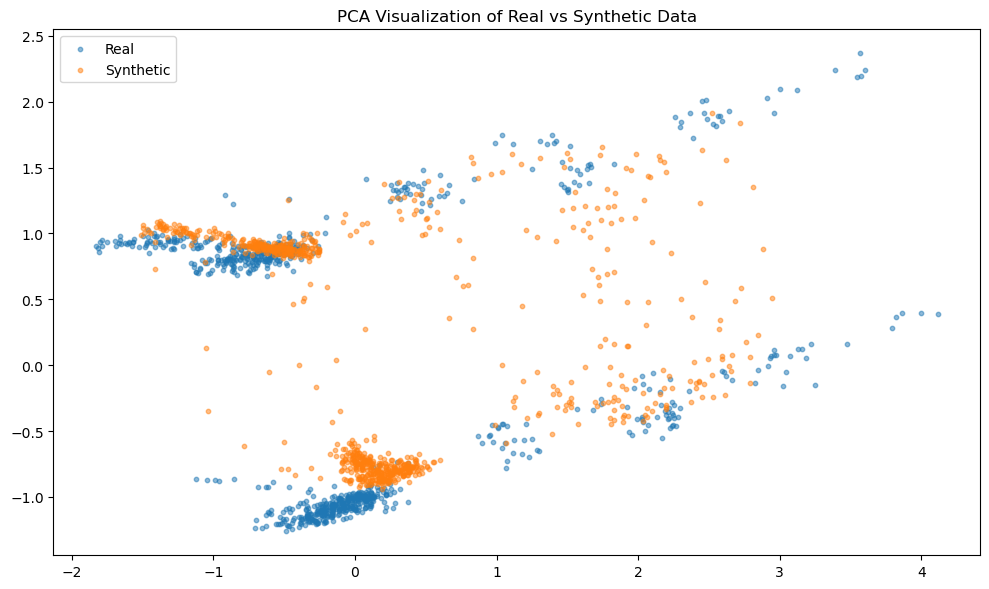

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

class SpectralNormalization(layers.Layer):
    def __init__(self, layer, iteration=1):
        super().__init__()
        self.iteration = iteration
        self.layer = layer
        self.kernel = self.layer.kernel
        
    def build(self, input_shape):
        self.u = self.add_weight(
            shape=(1, self.kernel.shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name='u'
        )
        
    def call(self, inputs):
        self._update_weights()
        return self.layer(inputs)
    
    def _update_weights(self):
        w_mat = tf.reshape(self.kernel, [-1, self.kernel.shape[-1]])
        u = self.u
        
        for _ in range(self.iteration):
            v = tf.matmul(u, tf.transpose(w_mat))
            v = v / tf.maximum(tf.norm(v), 1e-12)
            u = tf.matmul(v, w_mat)
            u = u / tf.maximum(tf.norm(u), 1e-12)
            
        u = tf.stop_gradient(u)
        v = tf.stop_gradient(v)
        sigma = tf.matmul(tf.matmul(v, w_mat), tf.transpose(u))
        
        self.kernel.assign(self.kernel / sigma)
        self.u.assign(u)

class MetricFocusedWGAN_GP:
    def __init__(self, input_dim, latent_dim=128, lambda_gp=10):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 5
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        # Separate feature extractor for better metric alignment
        self.feature_extractor = self._build_feature_extractor()
        
        self.g_optimizer = optimizers.AdamW(
            learning_rate=1e-4,
            weight_decay=1e-5,
            beta_1=0.0,  # Changed to 0.0 for better stability
            beta_2=0.9
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=1e-4,
            weight_decay=1e-5,
            beta_1=0.0,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        
        x = layers.Dense(512)(noise_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        # Focused architecture with residual connections
        for units in [1024, 512, 256]:
            skip = x
            x = SpectralNormalization(layers.Dense(units))(x)
            x = layers.LeakyReLU(0.2)(x)
            x = layers.LayerNormalization()(x)
            if skip.shape[-1] == units:
                x = x + skip
        
        # Multiple output paths for better feature preservation
        path1 = SpectralNormalization(layers.Dense(self.input_dim))(x)
        path2 = SpectralNormalization(layers.Dense(self.input_dim))(layers.Dense(256)(x))
        
        output = layers.Average()([path1, path2])
        output = layers.LayerNormalization()(output)
        output = layers.Activation('tanh')(output)
        
        return models.Model(noise_input, output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        
        x = SpectralNormalization(layers.Dense(512))(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        for units in [256, 128, 64]:
            x = SpectralNormalization(layers.Dense(units))(x)
            x = layers.LeakyReLU(0.2)(x)
            x = layers.LayerNormalization()(x)
        
        validity = SpectralNormalization(layers.Dense(1))(x)
        
        return models.Model(data_input, validity)

    def _build_feature_extractor(self):
        data_input = layers.Input(shape=(self.input_dim,))
        
        x = layers.Dense(256)(data_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        features = layers.LayerNormalization()(x)
        
        return models.Model(data_input, features)

    def reconstruction_loss(self, real_samples, fake_samples):
        # L1 loss for better detail preservation
        return tf.reduce_mean(tf.abs(real_samples - fake_samples))

    def feature_matching_loss(self, real_samples, fake_samples):
        real_features = self.feature_extractor(real_samples, training=False)
        fake_features = self.feature_extractor(fake_samples, training=False)
        return tf.reduce_mean(tf.abs(real_features - fake_features))

    @tf.function
    def train_step(self, real_samples, batch_size):
        # Small amount of noise for regularization
        real_samples = real_samples + tf.random.normal(tf.shape(real_samples), mean=0.0, stddev=0.01)
        
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_samples = self.generator(noise, training=True)
                
                real_validity = self.discriminator(real_samples, training=True)
                fake_validity = self.discriminator(fake_samples, training=True)
                
                # Gradient penalty
                gp = self.gradient_penalty(real_samples, fake_samples)
                
                # Discriminator loss with additional feature matching
                d_loss = (tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity) +
                         self.lambda_gp * gp)
            
            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        # Generator training with combined losses
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator(noise, training=True)
            fake_validity = self.discriminator(fake_samples, training=True)
            
            # Combine multiple loss terms for better metric optimization
            adversarial_loss = -tf.reduce_mean(fake_validity)
            recon_loss = self.reconstruction_loss(real_samples, fake_samples)
            feature_loss = self.feature_matching_loss(real_samples, fake_samples)
            
            g_loss = adversarial_loss + 0.1 * recon_loss + 0.1 * feature_loss
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, epochs=300, batch_size=64, early_stopping_patience=30):
        if isinstance(data, np.ndarray):
            data = tf.convert_to_tensor(data, dtype=tf.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)
        
        best_mse = float('inf')
        patience_counter = 0
        history = {'d_loss': [], 'g_loss': [], 'mse': []}
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch in dataset:
                d_loss, g_loss = self.train_step(batch, tf.shape(batch)[0])
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                test_samples = self.generate(1000)
                eval_data = data.numpy() if isinstance(data, tf.Tensor) else data
                metrics = evaluate_metrics(eval_data[:1000], test_samples, verbose=False)
                current_mse = metrics['MSE']
                
                history['d_loss'].append(tf.reduce_mean(d_losses))
                history['g_loss'].append(tf.reduce_mean(g_losses))
                history['mse'].append(current_mse)
                
                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}, G Loss: {tf.reduce_mean(g_losses):.4f}")
                print(f"MSE: {current_mse:.4f}")
                print(f"R-squared: {metrics['R-squared']:.4f}\n")
                
                if current_mse < best_mse:
                    best_mse = current_mse
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break
        
        return history

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            validity = self.discriminator(interpolated, training=True)
        
        gradients = tape.gradient(validity, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean(tf.square(gradients_norm - 1.0))
        return gradient_penalty

    def generate(self, num_samples):
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator(noise, training=False).numpy()

def load_and_preprocess_data(dataset_path=r"D:\apass9_cleaned.csv"):
    df = pd.read_csv(dataset_path).dropna()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)

    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    if synthetic_data.shape[0] > real_data.shape[0]:
        synthetic_data = synthetic_data[:real_data.shape[0]]

    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data)),
    }

    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)

        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except ValueError as e:
        print(f"Clustering Error: {e}")

    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics

def plot_distributions(real_data, synthetic_data):
    if isinstance(real_data, tf.Tensor):
        real_data = real_data.numpy()
    if isinstance(synthetic_data, tf.Tensor):
        synthetic_data = synthetic_data.numpy()

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization of Real vs Synthetic Data")
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing dataset...")
    original_data, scalers = load_and_preprocess_data()

    print("Initializing and training Improved WGAN-GP...")
    gan_model = ImprovedWGAN_GP(
        input_dim=original_data.shape[1],
        latent_dim=128,
        lambda_gp=10
    )

    gan_model.train(
        original_data,
        epochs=400,
        batch_size=128,
        early_stopping_patience=30
    )

    print("\nGenerating synthetic data...")
    synthetic_data = gan_model.generate(num_samples=original_data.shape[0])

    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)

    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)

if __name__ == "__main__":
    main()

# CONDITIONAL ADVERSARIAL NETWORKS- CGAN

### Overview of the Code

This code implements a Conditional Generative Adversarial Network (CGAN) with gradient penalty (WGAN-GP) that generates synthetic data based on conditional inputs. The model leverages advanced techniques like residual blocks and condition-specific layers for both the generator and discriminator, as well as a cosine decay learning rate schedule for improved training stability. Below is a breakdown of the key components and their roles:

1. **Imports and Libraries**  
   The necessary libraries for deep learning (TensorFlow, Keras), data processing (NumPy, pandas), clustering (KMeans), and evaluation (scikit-learn) are imported. Matplotlib and Seaborn are used for data visualization, while various metrics (MSE, R-squared, Silhouette Score, etc.) are computed to evaluate the quality of the generated synthetic data.

2. **Conditional Residual Block**  
   The `ConditionalResidualBlock` is a custom Keras layer that integrates both residual connections and conditioning information (e.g., from clustering labels). This block processes the input data and condition in parallel, adding the result to the original input to help retain learned features while promoting model stability.

3. **Enhanced Conditional Wasserstein GAN with Gradient Penalty (EnhancedCWGAN_GP)**  
   This class implements the CGAN architecture with:
   - **Generator:** The generator combines noise and conditional inputs (e.g., cluster labels) to create synthetic data. It uses multiple conditional residual blocks to progressively refine the generated data.
   - **Discriminator:** The discriminator evaluates whether data is real or fake, with an emphasis on conditioning information. It also uses residual blocks and layer normalization.
   - **Gradient Penalty:** The `gradient_penalty` method enforces the Lipschitz constraint on the discriminator’s gradients, which stabilizes training.
   - **Training Step:** The `train_step` function alternates between training the discriminator and generator. The discriminator is updated multiple times before updating the generator to improve the model's ability to differentiate real and fake samples.
   - **Learning Rate Schedule:** The learning rate for both the generator and discriminator is adjusted using a cosine decay schedule, which helps optimize training.

4. **Data Preprocessing**  
   The `load_and_preprocess_data` function loads the dataset, normalizes it using both `StandardScaler` and `MinMaxScaler`, and returns the processed data ready for training.

5. **Metrics Evaluation**  
   The `evaluate_metrics` function calculates various performance metrics to assess how well the synthetic data matches the real data:
   - **MSE (Mean Squared Error)** and **R-squared**: To measure the similarity in values between real and synthetic data.
   - **Wasserstein Distance**: A measure of the difference between the distributions of real and synthetic data.
   - **Clustering Metrics**: Using KMeans clustering, metrics like **Silhouette Score**, **Calinski-Harabasz Score**, and **Davies-Bouldin Score** evaluate the clustering structure of both real and synthetic data.

6. **Visualization**  
   The `plot_distributions` function visualizes the data distributions by performing a PCA transformation to reduce the data to 2D and plotting both the real and synthetic data. It also plots the KDEs of the individual features to compare their distributions.

7. **Main Function**  
   The `main` function orchestrates the workflow:
   - Loads and preprocesses the dataset.
   - Creates conditions using clustering (KMeans) for the generator and discriminator.
   - Initializes and trains the CGAN model.
   - Generates synthetic data after training.
   - Evaluates the generated synthetic data using various metrics.
   - Visualizes the comparison between real and synthetic data.

8. **Training Configuration**  
   The model is configured to run for 400 epochs with a batch size of 64. Early stopping is implemented to prevent overfitting if the model's performance does not improve for 50 epochs.

### Conclusion
This code demonstrates the use of a Conditional GAN with gradient penalty to generate synthetic data based on specific conditions (e.g., clustering labels). The enhanced residual blocks and advanced learning rate scheduling techniques improve model performance and stability. Evaluation through various metrics and visualizations helps assess the quality of the generated data, making this framework useful for generating high-quality synthetic datasets in machine learning applications.


Loading data...
Preprocessing...
Creating conditions using clustering...
Initializing CGAN...

Training CGAN...
Epoch 0
D Loss: -1.9221
G Loss: 1.1208

Epoch 10
D Loss: -2.2984
G Loss: 0.0175

Epoch 20
D Loss: -2.0821
G Loss: 1.5205

Epoch 30
D Loss: -1.7917
G Loss: 1.3432

Epoch 40
D Loss: -1.4755
G Loss: 1.1772

Epoch 50
D Loss: -1.2175
G Loss: 0.9545

Epoch 60
D Loss: -1.1601
G Loss: 0.5528

Epoch 70
D Loss: -1.1569
G Loss: 0.6176

Epoch 80
D Loss: -1.1910
G Loss: 0.0791

Epoch 90
D Loss: -0.9476
G Loss: 0.4546

Epoch 100
D Loss: -0.8074
G Loss: 0.2209

Epoch 110
D Loss: -0.7032
G Loss: 0.4035

Epoch 120
D Loss: -0.5613
G Loss: 0.1323

Epoch 130
D Loss: -0.4084
G Loss: -0.3890

Epoch 140
D Loss: -0.3290
G Loss: -0.4077

Epoch 150
D Loss: -0.3115
G Loss: -0.5628

Epoch 160
D Loss: -0.2390
G Loss: -0.6601

Epoch 170
D Loss: -0.2359
G Loss: -0.5635

Epoch 180
D Loss: -0.2041
G Loss: -0.5775

Epoch 190
D Loss: -0.1873
G Loss: -0.5438

Epoch 200
D Loss: -0.1952
G Loss: -0.5927

Epoch 210

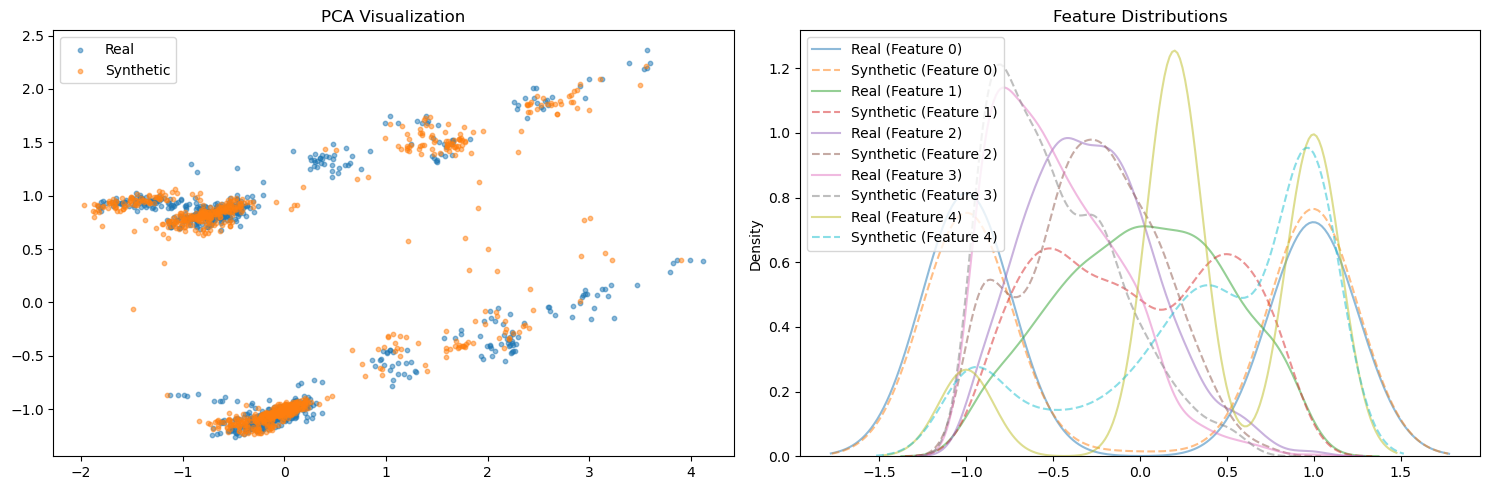


Saving results...

Training complete!
Synthetic data shape: (837, 24)
Original data shape: (837, 24)

Script completed successfully!


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

class ConditionalResidualBlock(layers.Layer):
    def __init__(self, units, condition_dim, dropout_rate=0.3):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.condition_dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)

        self.dense2 = layers.Dense(units)
        self.condition_dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)

        self.residual = layers.Dense(units)
        self.condition_residual = layers.Dense(units)

    def call(self, inputs, training=False):
        x, condition = inputs
        
        # Process condition
        condition1 = self.condition_dense1(condition)
        condition2 = self.condition_dense2(condition)
        condition_res = self.condition_residual(condition)
        
        # Main path
        residual = self.residual(x) + condition_res
        
        x = self.dense1(x) + condition1
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x) + condition2
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class EnhancedCWGAN_GP:
    def __init__(self, input_dim, condition_dim, latent_dim=256, lambda_gp=10):
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.n_critic = 5
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        
        # Advanced learning rate scheduling
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9
        )
        
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-5,
            beta_1=0.5,
            beta_2=0.9
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-5,
            beta_1=0.5,
            beta_2=0.9
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([noise_input, condition_input])
        
        x = layers.Dense(512)(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ConditionalResidualBlock(1024, self.condition_dim)([x, condition_input])
        x = ConditionalResidualBlock(2048, self.condition_dim)([x, condition_input])
        x = ConditionalResidualBlock(4096, self.condition_dim)([x, condition_input])
        
        x = layers.Dense(2048)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        direct_mapping = layers.Dense(self.input_dim)(combined_input)
        main_output = layers.Dense(self.input_dim)(x)
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)
        
        return models.Model([noise_input, condition_input], output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([data_input, condition_input])
        
        x = layers.Dense(2048)(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ConditionalResidualBlock(1024, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ConditionalResidualBlock(512, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ConditionalResidualBlock(256, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        output = layers.Dense(1)(x)
        
        return models.Model([data_input, condition_input], output)

    def gradient_penalty(self, real_samples, fake_samples, conditions):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            interpolated_predictions = self.discriminator([interpolated, conditions], training=True)
        
        gradients = tape.gradient(interpolated_predictions, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, conditions, batch_size):
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, conditions], training=True)
                real_output = self.discriminator([real_samples, conditions], training=True)
                fake_output = self.discriminator([fake_samples, conditions], training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples, conditions)
                d_loss = (tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) +
                         self.lambda_gp * gp)
            
            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator([noise, conditions], training=True)
            fake_output = self.discriminator([fake_samples, conditions], training=True)
            g_loss = -tf.reduce_mean(fake_output)
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, conditions, epochs=200, batch_size=64, early_stopping_patience=50):
        dataset = tf.data.Dataset.from_tensor_slices((data, conditions))
        dataset = dataset.shuffle(10000).batch(batch_size)
        
        best_wasserstein = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch_data, batch_conditions in dataset:
                d_loss, g_loss = self.train_step(
                    batch_data, 
                    batch_conditions,
                    tf.shape(batch_data)[0]
                )
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}")
                print(f"D Loss: {tf.reduce_mean(d_losses):.4f}")
                print(f"G Loss: {tf.reduce_mean(g_losses):.4f}\n")
                
                current_wasserstein = tf.reduce_mean(d_losses)
                if current_wasserstein < best_wasserstein:
                    best_wasserstein = current_wasserstein
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, conditions, num_samples=None):
        if num_samples is None:
            num_samples = conditions.shape[0]
        
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator([noise, conditions], training=False)

def load_and_preprocess_data(dataset_path):
    print("Loading data...")
    df = pd.read_csv(dataset_path).dropna()
    
    print("Preprocessing...")
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)
    
    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data))
    }
    
    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)
        
        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except Exception as e:
        print(f"Clustering metrics calculation error: {e}")
    
    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_distributions(real_data, synthetic_data):
    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)
    
    plt.figure(figsize=(15, 5))
    
    # PCA scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization")
    
    # Density plot
    plt.subplot(1, 2, 2)
    for i in range(min(5, real_data.shape[1])):
        sns.kdeplot(data=real_data[:, i], label=f'Real (Feature {i})', alpha=0.5)
        sns.kdeplot(data=synthetic_data[:, i], label=f'Synthetic (Feature {i})', alpha=0.5, linestyle='--')
    plt.title("Feature Distributions")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    data_path = r"D:\apass9_cleaned.csv"  # Replace with your data path
    original_data, scalers = load_and_preprocess_data(data_path)
    
    # Create conditions using clustering
    print("Creating conditions using clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(original_data)
    conditions = tf.one_hot(cluster_labels, depth=n_clusters)
    
    # Initialize and train the model
    print("Initializing CGAN...")
    cgan_model = EnhancedCWGAN_GP(
        input_dim=original_data.shape[1],
        condition_dim=conditions.shape[1],
        latent_dim=256,
        lambda_gp=10
    )
    
    print("Training CGAN...")
    cgan_model.train(
        original_data,
        conditions,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )
    
    # Generate and evaluate synthetic data
    print("Generating synthetic data...")
    synthetic_data = cgan_model.generate(conditions).numpy()
    
    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)
    
    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)
    
    # Save the results
    print("\nSaving results...")
    np.save('synthetic_data.npy', synthetic_data)
    
    # Print final summary
    print("\nTraining complete!")
    print("Synthetic data shape:", synthetic_data.shape)
    print("Original data shape:", original_data.shape)
    
    return cgan_model, synthetic_data, metrics

if __name__ == "__main__":
    # Enable memory growth for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    try:
        model, synthetic_data, metrics = main()
        print("\nScript completed successfully!")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

# Contrastive Adversarial Networks - ContraGAN

## ContraGAN: A Contrastive Adversarial Network for Generating Synthetic Data

This notebook implements a **Contrastive Adversarial Network** (ContraGAN) for generating synthetic data using both **adversarial training** and **contrastive loss**. The model combines the strengths of **Generative Adversarial Networks (GANs)** with a contrastive approach to learn representations that align real and generated data in a shared space.

## Key Components:

1. **ContrastiveResidualBlock (Custom Layer)**:
   - A custom residual block used in both the generator and discriminator.
   - Takes input data and a conditioning vector (e.g., cluster labels) and processes them through multiple dense layers with leaky ReLU activations, layer normalization, and dropout.
   - The residual connection helps to improve the learning of complex dependencies and stabilizes training.

2. **ContraGAN Class**:
   - **Generator**: Takes random noise and a conditioning vector (derived from clustering) and generates synthetic data that mimics the original data.
   - **Discriminator**: Distinguishes between real and synthetic data, outputting both a validity score (real vs fake) and a feature representation for contrastive loss calculation.
   - **Projector**: Maps the feature representations of both real and fake data into a shared space to calculate the contrastive loss, encouraging alignment between real and synthetic data features.
   
   **Loss Functions**:
   - **Wasserstein Loss**: Measures the distance between real and generated data using the Wasserstein distance, encouraging better quality synthetic data.
   - **Contrastive Loss**: Ensures that feature representations of real and synthetic data remain close in the shared feature space.
   - **Gradient Penalty**: Regularizes the discriminator’s gradients to encourage smoothness, which is crucial for training Wasserstein GANs.

3. **Data Preprocessing**:
   - The dataset is loaded and standardized using **StandardScaler** and **MinMaxScaler** to ensure data consistency.
   - **KMeans clustering** is applied to create cluster labels, which are used as conditions for the generator and discriminator.

4. **Metrics Evaluation**:
   - **Mean Squared Error (MSE)** and **R-squared** values are used to compare the similarity between real and synthetic data.
   - **Clustering metrics** (e.g., Silhouette Score, Davies-Bouldin Score) are computed to evaluate how well the synthetic data matches the real data distribution in terms of clusters.

5. **Visualizations**:
   - **PCA Visualization**: A 2D PCA scatter plot is used to visually compare the distribution of real and synthetic data.
   - **Feature Distribution**: Kernel density plots compare the feature distributions of real and synthetic data, providing an intuitive understanding of how well the synthetic data matches the original.

## How the Model Works:

1. **Data Loading and Preprocessing**:
   - The dataset is read from a CSV file and preprocessed by scaling it using `StandardScaler` and `MinMaxScaler`.
   - KMeans clustering is used to generate conditions (cluster labels) that guide the generation process.

2. **Training the Model**:
   - The **generator** and **discriminator** are trained in an adversarial setup. The discriminator tries to distinguish real from fake data, while the generator aims to fool the discriminator.
   - The **contrastive loss** helps the generator and discriminator learn aligned feature representations, while the **gradient penalty** stabilizes training.
   
3. **Generating and Evaluating Synthetic Data**:
   - After training, synthetic data is generated by passing random noise and conditions to the generator.
   - The quality of the generated data is assessed using various metrics, including **MSE**, **Silhouette Score**, and **Wasserstein Distance**.

4. **Visualization**:
   - The generated synthetic data is compared with the original data using **PCA** for dimensionality reduction and visualized using **density plots** for each feature.

## Usage:

1. **Dataset**:
   - A CSV dataset (`apass9_cleaned.csv`) is expected to be provided for training. You can replace this dataset with any suitable dataset for your task.

2. **Model Training**:
   - Hyperparameters such as the latent dimension, batch size, and number of epochs can be tuned in the `train()` function to fit the dataset.
   - The `train_step()` function performs the adversarial training loop, updating both the generator and the discriminator.

3. **Synthetic Data Generation**:
   - After training, synthetic data can be generated by calling the `generate()` function on the trained model.

4. **Evaluation and Visualization**:
   - The model's performance can be evaluated using the `evaluate_metrics()` function, which computes MSE, clustering scores, and Wasserstein distance.
   - The `plot_distributions()` function helps visualize the comparison between real and synthetic data in terms of feature distributions.

## Requirements:
- TensorFlow: For model definition and training.
- NumPy: For array operations.
- Pandas: For data loading and manipulation.
- Scikit-learn: For clustering and evaluation metrics.
- Matplotlib & Seaborn: For plotting visualizations.

## Example Output:
- The model prints the **generator** and **discriminator losses** during training, and once training is complete, it generates synthetic data.
- Various metrics like **MSE**, **Silhouette Score**, and **Davies-Bouldin Score** are displayed to evaluate the quality of the synthetic data.
- **PCA scatter plots** and **density plots** are shown to visualize how well the synthetic data mimics the real data distribution.

## Conclusion:
This implementation demonstrates how to combine GANs with contrastive learning to generate high-quality synthetic data that closely resembles the real data distribution. By using a contrastive loss, the model ensures that generated data features align with real data features in a shared space, improving the overall quality of synthetic data generation.



Loading data...
Preprocessing...
Creating conditions using clustering...
Initializing ContraGAN...

Training ContraGAN...
Epoch 0
D Loss: -1.5018
G Loss: 1.9714

Epoch 10
D Loss: -2.5068
G Loss: 0.1023

Epoch 20
D Loss: -2.2265
G Loss: 0.4985

Epoch 30
D Loss: -1.2125
G Loss: 2.6966

Epoch 40
D Loss: -0.8538
G Loss: 2.9937

Epoch 50
D Loss: -0.7968
G Loss: 3.9534

Epoch 60
D Loss: -0.7769
G Loss: 4.1260

Epoch 70
D Loss: -0.7288
G Loss: 4.3281

Epoch 80
D Loss: -0.7904
G Loss: 4.5154

Epoch 90
D Loss: -0.6161
G Loss: 4.4522

Epoch 100
D Loss: -0.4976
G Loss: 4.4106

Epoch 110
D Loss: -0.4345
G Loss: 5.1048

Epoch 120
D Loss: -0.3864
G Loss: 4.8153

Epoch 130
D Loss: -0.3530
G Loss: 4.3079

Epoch 140
D Loss: -0.3142
G Loss: 4.6957

Epoch 150
D Loss: -0.2587
G Loss: 4.7869

Epoch 160
D Loss: -0.1168
G Loss: 3.9384

Epoch 170
D Loss: -0.1752
G Loss: 3.5185

Epoch 180
D Loss: 0.1377
G Loss: 3.7047

Epoch 190
D Loss: 0.2417
G Loss: 3.6502

Epoch 200
D Loss: -0.1444
G Loss: 3.3514

Epoch 210

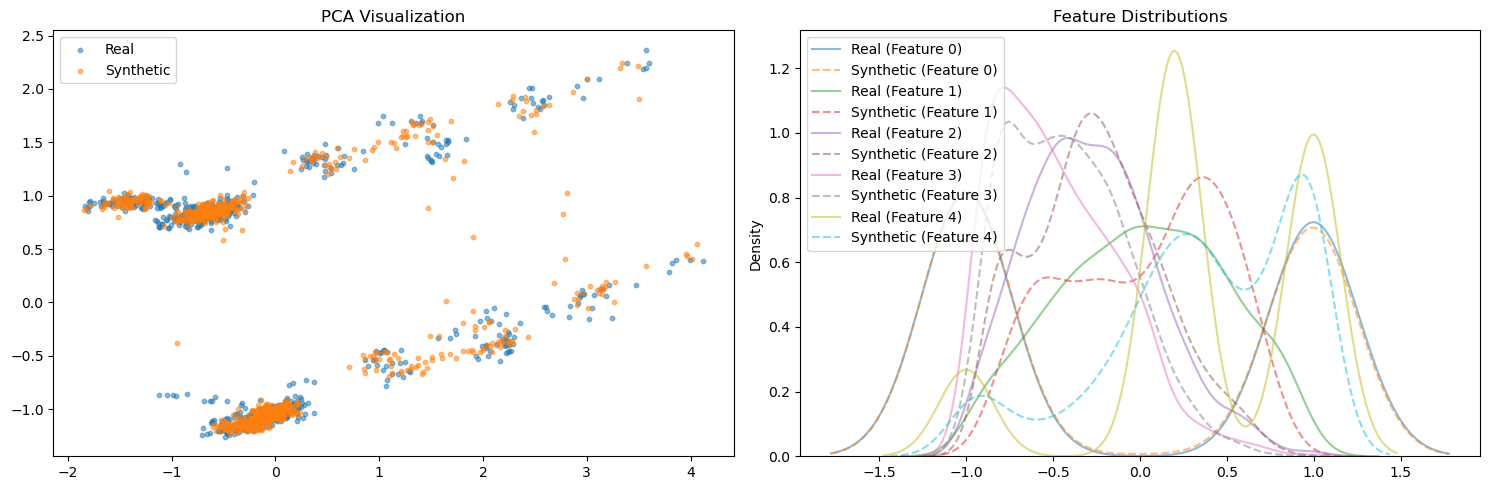


Saving results...

Training complete!
Synthetic data shape: (837, 24)
Original data shape: (837, 24)

Script completed successfully!


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

class ContrastiveResidualBlock(layers.Layer):
    def __init__(self, units, condition_dim, dropout_rate=0.3):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.condition_dense1 = layers.Dense(units)
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(dropout_rate)
        
        self.dense2 = layers.Dense(units)
        self.condition_dense2 = layers.Dense(units)
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(dropout_rate)
        
        self.residual = layers.Dense(units)
        self.condition_residual = layers.Dense(units)

    def call(self, inputs, training=False):
        x, condition = inputs
        
        condition1 = self.condition_dense1(condition)
        condition2 = self.condition_dense2(condition)
        condition_res = self.condition_residual(condition)
        
        residual = self.residual(x) + condition_res
        
        x = self.dense1(x) + condition1
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x) + condition2
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

class ContraGAN:
    def __init__(self, input_dim, condition_dim, latent_dim=256, lambda_gp=10, temperature=0.5):
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.temperature = temperature
        self.n_critic = 5
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.projector = self._build_projector()
        
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9,
            alpha=1e-5
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=1e-4,
            first_decay_steps=1000,
            t_mul=2.0,
            m_mul=0.9,
            alpha=1e-5
        )
        
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.999,
            clipnorm=1.0
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=1e-4,
            beta_1=0.5,
            beta_2=0.999,
            clipnorm=1.0
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([noise_input, condition_input])
        
        x = layers.Dense(512, kernel_initializer='he_normal')(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ContrastiveResidualBlock(1024, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(2048, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(4096, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(2048, self.condition_dim)([x, condition_input])
        
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        direct_mapping = layers.Dense(self.input_dim)(combined_input)
        main_output = layers.Dense(self.input_dim)(x)
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)
        
        return models.Model([noise_input, condition_input], output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        combined_input = layers.Concatenate()([data_input, condition_input])
        
        x = layers.Dense(2048)(combined_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = ContrastiveResidualBlock(1024, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ContrastiveResidualBlock(512, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        x = ContrastiveResidualBlock(256, self.condition_dim, dropout_rate=0.3)([x, condition_input])
        
        features = layers.Dense(128)(x)
        features = layers.LeakyReLU(0.2)(features)
        features = layers.LayerNormalization()(features)
        
        validity = layers.Dense(1)(features)
        
        return models.Model([data_input, condition_input], [validity, features])

    def _build_projector(self):
        feature_input = layers.Input(shape=(128,))
        
        x = layers.Dense(256)(feature_input)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.LayerNormalization()(x)
        
        x = layers.Dense(128)(x)
        x = layers.LayerNormalization()(x)
        
        return models.Model(feature_input, x)

    def contrastive_loss(self, features_real, features_fake):
        features_real = tf.nn.l2_normalize(features_real, axis=1)
        features_fake = tf.nn.l2_normalize(features_fake, axis=1)
        
        similarity_matrix = tf.matmul(features_real, features_fake, transpose_b=True)
        similarity_matrix = similarity_matrix / self.temperature
        
        labels = tf.eye(tf.shape(features_real)[0])
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=similarity_matrix))
        
        return loss

    def gradient_penalty(self, real_samples, fake_samples, conditions):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            validity, _ = self.discriminator([interpolated, conditions], training=True)
        
        gradients = tape.gradient(validity, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    @tf.function
    def train_step(self, real_samples, conditions, batch_size):
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, conditions], training=True)
                
                real_validity, real_features = self.discriminator([real_samples, conditions], training=True)
                fake_validity, fake_features = self.discriminator([fake_samples, conditions], training=True)
                
                real_proj = self.projector(real_features, training=True)
                fake_proj = self.projector(fake_features, training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples, conditions)
                wasserstein_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity)
                contrastive_d_loss = self.contrastive_loss(real_proj, fake_proj)
                
                d_loss = wasserstein_loss + self.lambda_gp * gp + 0.1 * contrastive_d_loss
            
            d_gradients = tape.gradient(d_loss, 
                self.discriminator.trainable_variables + self.projector.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradients, 
                    self.discriminator.trainable_variables + self.projector.trainable_variables))
        
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator([noise, conditions], training=True)
            
            fake_validity, fake_features = self.discriminator([fake_samples, conditions], training=True)
            real_validity, real_features = self.discriminator([real_samples, conditions], training=True)
            
            real_proj = self.projector(real_features, training=True)
            fake_proj = self.projector(fake_features, training=True)
            
            wasserstein_loss = -tf.reduce_mean(fake_validity)
            contrastive_g_loss = self.contrastive_loss(fake_proj, real_proj)
            
            g_loss = wasserstein_loss + 0.1 * contrastive_g_loss
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, conditions, epochs=200, batch_size=64, early_stopping_patience=50):
        dataset = tf.data.Dataset.from_tensor_slices((data, conditions))
        dataset = dataset.shuffle(10000).batch(batch_size)
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch_data, batch_conditions in dataset:
                d_loss, g_loss = self.train_step(
                    batch_data, 
                    batch_conditions,
                    tf.shape(batch_data)[0]
                )
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                d_loss_mean = tf.reduce_mean(d_losses)
                g_loss_mean = tf.reduce_mean(g_losses)
                print(f"Epoch {epoch}")
                print(f"D Loss: {d_loss_mean:.4f}")
                print(f"G Loss: {g_loss_mean:.4f}\n")
                
                current_loss = d_loss_mean + g_loss_mean
                if current_loss < best_loss:
                    best_loss = current_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, conditions, num_samples=None):
        if num_samples is None:
            num_samples = conditions.shape[0]
        
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator([noise, conditions], training=False)

def load_and_preprocess_data(dataset_path):
    print("Loading data...")
    df = pd.read_csv(dataset_path).dropna()
    
    print("Preprocessing...")
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)
    
    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data))
    }
    
    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)
        
        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except Exception as e:
        print(f"Clustering metrics calculation error: {e}")
    
    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_distributions(real_data, synthetic_data):
    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)
    
    plt.figure(figsize=(15, 5))
    
    # PCA scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization")
    
    # Density plot
    plt.subplot(1, 2, 2)
    for i in range(min(5, real_data.shape[1])):
        sns.kdeplot(data=real_data[:, i], label=f'Real (Feature {i})', alpha=0.5)
        sns.kdeplot(data=synthetic_data[:, i], label=f'Synthetic (Feature {i})', alpha=0.5, linestyle='--')
    plt.title("Feature Distributions")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    data_path = r"D:\apass9_cleaned.csv"  
    original_data, scalers = load_and_preprocess_data(data_path)
    
    # Create conditions using clustering
    print("Creating conditions using clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(original_data)
    conditions = tf.one_hot(cluster_labels, depth=n_clusters)
    
    # Initialize and train the model
    print("Initializing ContraGAN...")
    cgan_model = ContraGAN(
        input_dim=original_data.shape[1],
        condition_dim=conditions.shape[1],
        latent_dim=256,
        lambda_gp=10
    )
    
    print("Training ContraGAN...")
    cgan_model.train(
        original_data,
        conditions,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )
    
    # Generate and evaluate synthetic data
    print("Generating synthetic data...")
    synthetic_data = cgan_model.generate(conditions).numpy()
    
    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)
    
    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)
    
    # Save the results
    print("\nSaving results...")
    np.save('synthetic_data.npy', synthetic_data)
    
    # Print final summary
    print("\nTraining complete!")
    print("Synthetic data shape:", synthetic_data.shape)
    print("Original data shape:", original_data.shape)
    
    return cgan_model, synthetic_data, metrics

if __name__ == "__main__":
    # Enable memory growth for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    try:
        model, synthetic_data, metrics = main()
        print("\nScript completed successfully!")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")


Improving it

Loading data...
Preprocessing...
Creating conditions using clustering...
Initializing ContraGAN...
Training ContraGAN...
Epoch 0
D Loss: -0.4548
G Loss: 0.5888

Epoch 10
D Loss: -0.8847
G Loss: -0.9392

Epoch 20
D Loss: -0.8142
G Loss: 0.0757

Epoch 30
D Loss: -0.6586
G Loss: 0.6046

Epoch 40
D Loss: -0.5897
G Loss: 1.8506

Epoch 50
D Loss: -0.4777
G Loss: 1.5039

Epoch 60
D Loss: -0.3971
G Loss: 0.7778

Epoch 70
D Loss: -0.3276
G Loss: -0.2875

Epoch 80
D Loss: -0.2441
G Loss: -1.0101

Epoch 90
D Loss: -0.2066
G Loss: -1.3363

Epoch 100
D Loss: -0.1504
G Loss: -1.4760

Epoch 110
D Loss: -0.1475
G Loss: -1.4160

Epoch 120
D Loss: -0.1199
G Loss: -1.3956

Epoch 130
D Loss: -0.1555
G Loss: -1.3200

Epoch 140
D Loss: -0.1578
G Loss: -1.0429

Epoch 150
D Loss: -0.2132
G Loss: -1.1944

Epoch 160
D Loss: -0.1474
G Loss: -0.4610

Epoch 170
D Loss: -0.0601
G Loss: -0.1991

Epoch 180
D Loss: 2.8683
G Loss: 1.2251

Epoch 190
D Loss: -0.0089
G Loss: 4.1116

Epoch 200
D Loss: 0.0194
G Loss: 8.4259

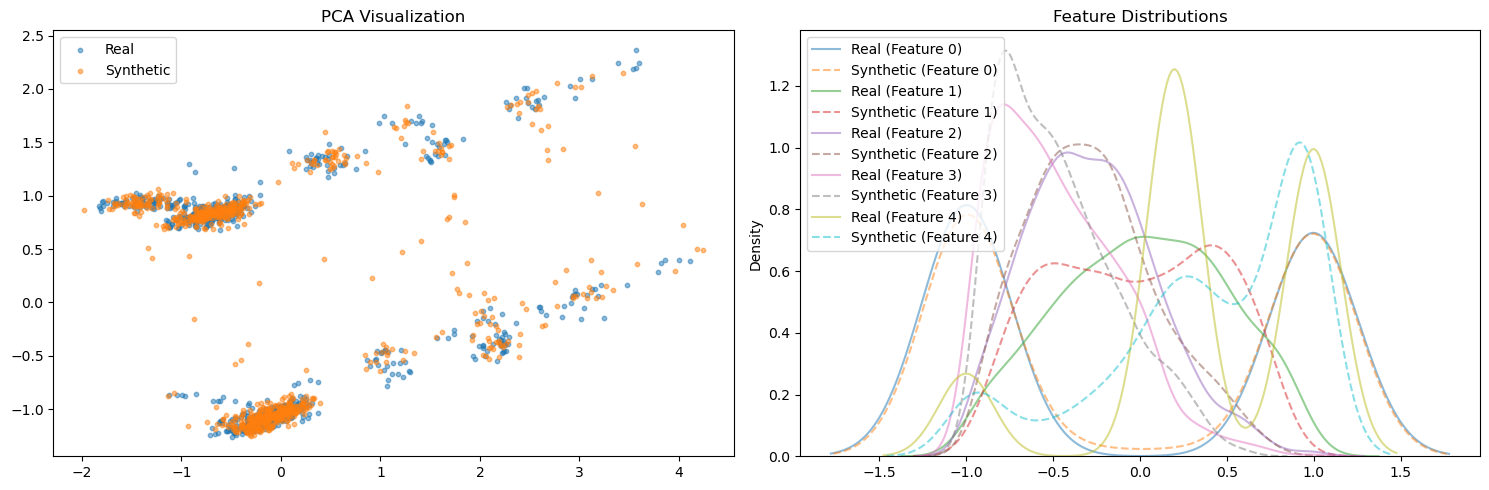


Saving results...

Training complete!
Synthetic data shape: (837, 24)
Original data shape: (837, 24)

Script completed successfully!


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

class ContrastiveResidualBlock(layers.Layer):
    def __init__(self, units, condition_dim, dropout_rate=0.2):
        super().__init__()
        self.units = units
        self.condition_dim = condition_dim
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        x_shape, condition_shape = input_shape
        
        # Main path layers
        self.dense1 = layers.Dense(self.units, kernel_initializer='he_normal')
        self.condition_dense1 = layers.Dense(self.units, kernel_initializer='he_normal')
        self.ln1 = layers.LayerNormalization()
        self.leaky1 = layers.LeakyReLU(0.1)
        self.dropout1 = layers.Dropout(self.dropout_rate)
        
        self.dense2 = layers.Dense(self.units, kernel_initializer='he_normal')
        self.condition_dense2 = layers.Dense(self.units, kernel_initializer='he_normal')
        self.ln2 = layers.LayerNormalization()
        self.leaky2 = layers.LeakyReLU(0.1)
        self.dropout2 = layers.Dropout(self.dropout_rate)
        
        # Skip connection layers
        self.skip = layers.Dense(self.units, kernel_initializer='he_normal')
        self.condition_skip = layers.Dense(self.units, kernel_initializer='he_normal')
        
        super().build(input_shape)

    def call(self, inputs, training=False):
        x, condition = inputs[0], inputs[1]
        
        # Skip connection
        skip = self.skip(x)
        condition_skip = self.condition_skip(condition)
        residual = skip + condition_skip
        
        # Main path
        x = self.dense1(x)
        condition1 = self.condition_dense1(condition)
        x = x + condition1
        x = self.ln1(x)
        x = self.leaky1(x)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x)
        condition2 = self.condition_dense2(condition)
        x = x + condition2
        x = self.ln2(x)
        x = self.leaky2(x)
        x = self.dropout2(x, training=training)
        
        return x + residual

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.units)

class ContraGAN:
    def __init__(self, input_dim, condition_dim, latent_dim=256, lambda_gp=10, temperature=0.07):
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.temperature = temperature
        self.n_critic = 4
        
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.projector = self._build_projector()
        
        # Learning rate schedules
        self.g_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=2000,
            t_mul=2.0,
            m_mul=0.95,
            alpha=2e-5
        )
        self.d_lr_schedule = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=2e-4,
            first_decay_steps=2000,
            t_mul=2.0,
            m_mul=0.95,
            alpha=2e-5
        )
        
        # Optimizers
        self.g_optimizer = optimizers.AdamW(
            learning_rate=self.g_lr_schedule,
            weight_decay=2e-4,
            beta_1=0.5,
            beta_2=0.9,
            clipnorm=1.0
        )
        self.d_optimizer = optimizers.AdamW(
            learning_rate=self.d_lr_schedule,
            weight_decay=2e-4,
            beta_1=0.5,
            beta_2=0.9,
            clipnorm=1.0
        )

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        # Input processing
        noise_encoded = layers.Dense(self.latent_dim, kernel_initializer='he_normal')(noise_input)
        noise_encoded = layers.LeakyReLU(0.1)(noise_encoded)
        
        condition_encoded = layers.Dense(self.latent_dim, kernel_initializer='he_normal')(condition_input)
        condition_encoded = layers.LeakyReLU(0.1)(condition_encoded)
        
        x = layers.Concatenate()([noise_encoded, condition_encoded])
        x = layers.Dense(512, kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.LayerNormalization()(x)
        
        # Residual blocks
        x = ContrastiveResidualBlock(1024, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(2048, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(1024, self.condition_dim)([x, condition_input])
        
        # Output processing
        x = layers.Dense(512, kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.LayerNormalization()(x)
        
        # Direct mapping for residual connection
        direct_mapping = layers.Dense(self.input_dim, kernel_initializer='he_normal')(layers.Concatenate()([noise_input, condition_input]))
        main_output = layers.Dense(self.input_dim, kernel_initializer='he_normal')(x)
        
        output = layers.Add()([direct_mapping, main_output])
        output = layers.Activation('tanh')(output)
        
        return models.Model([noise_input, condition_input], output)

    def _build_discriminator(self):
        data_input = layers.Input(shape=(self.input_dim,))
        condition_input = layers.Input(shape=(self.condition_dim,))
        
        # Input processing
        x = layers.Concatenate()([data_input, condition_input])
        x = layers.Dense(1024, kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.LayerNormalization()(x)
        
        # Residual blocks
        x = ContrastiveResidualBlock(512, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(256, self.condition_dim)([x, condition_input])
        x = ContrastiveResidualBlock(128, self.condition_dim)([x, condition_input])
        
        # Feature extraction
        features = layers.Dense(128, kernel_initializer='he_normal')(x)
        features = layers.LeakyReLU(0.1)(features)
        features = layers.LayerNormalization()(features)
        
        # Validity output
        validity = layers.Dense(1)(features)
        
        return models.Model([data_input, condition_input], [validity, features])

    def _build_projector(self):
        feature_input = layers.Input(shape=(128,))
        
        x = layers.Dense(256, kernel_initializer='he_normal')(feature_input)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.LayerNormalization()(x)
        
        x = layers.Dense(128, kernel_initializer='he_normal')(x)
        x = layers.LayerNormalization()(x)
        
        return models.Model(feature_input, x)

    def gradient_penalty(self, real_samples, fake_samples, conditions):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform((batch_size, 1), 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            validity, _ = self.discriminator([interpolated, conditions], training=True)
        
        gradients = tape.gradient(validity, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gradient_penalty

    def contrastive_loss(self, features_real, features_fake):
        features_real = tf.nn.l2_normalize(features_real, axis=1)
        features_fake = tf.nn.l2_normalize(features_fake, axis=1)
        
        similarity_matrix = tf.matmul(features_real, features_fake, transpose_b=True)
        similarity_matrix = similarity_matrix / self.temperature
        
        labels = tf.eye(tf.shape(features_real)[0])
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=similarity_matrix))
        
        return loss

    @tf.function
    def train_step(self, real_samples, conditions, batch_size):
        # Enhanced training step with improved loss balancing
        for _ in range(self.n_critic):
            noise = tf.random.normal((batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                fake_samples = self.generator([noise, conditions], training=True)
                
                real_validity, real_features = self.discriminator([real_samples, conditions], training=True)
                fake_validity, fake_features = self.discriminator([fake_samples, conditions], training=True)
                
                real_proj = self.projector(real_features, training=True)
                fake_proj = self.projector(fake_features, training=True)
                
                gp = self.gradient_penalty(real_samples, fake_samples, conditions)
                wasserstein_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity)
                contrastive_d_loss = self.contrastive_loss(real_proj, fake_proj)
                
                # Improved loss weights
                d_loss = wasserstein_loss + self.lambda_gp * gp + 0.2 * contrastive_d_loss
            
            d_gradients = tape.gradient(d_loss, 
                self.discriminator.trainable_variables + self.projector.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradients, 
                    self.discriminator.trainable_variables + self.projector.trainable_variables))
        
        # Generator training with improved loss balancing
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_samples = self.generator([noise, conditions], training=True)
            
            fake_validity, fake_features = self.discriminator([fake_samples, conditions], training=True)
            real_validity, real_features = self.discriminator([real_samples, conditions], training=True)
            
            real_proj = self.projector(real_features, training=True)
            fake_proj = self.projector(fake_features, training=True)
            
            wasserstein_loss = -tf.reduce_mean(fake_validity)
            contrastive_g_loss = self.contrastive_loss(fake_proj, real_proj)
            
            # Improved loss weights
            g_loss = wasserstein_loss + 0.2 * contrastive_g_loss
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return d_loss, g_loss

    def train(self, data, conditions, epochs=300, batch_size=128, early_stopping_patience=30):
        dataset = tf.data.Dataset.from_tensor_slices((data, conditions))
        dataset = dataset.shuffle(10000).batch(batch_size)
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            
            for batch_data, batch_conditions in dataset:
                d_loss, g_loss = self.train_step(
                    batch_data, 
                    batch_conditions,
                    tf.shape(batch_data)[0]
                )
                d_losses.append(d_loss)
                g_losses.append(g_loss)
            
            if epoch % 10 == 0:
                d_loss_mean = tf.reduce_mean(d_losses)
                g_loss_mean = tf.reduce_mean(g_losses)
                print(f"Epoch {epoch}")
                print(f"D Loss: {d_loss_mean:.4f}")
                print(f"G Loss: {g_loss_mean:.4f}\n")
                
                current_loss = d_loss_mean + g_loss_mean
                if current_loss < best_loss:
                    best_loss = current_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

    def generate(self, conditions, num_samples=None):
        if num_samples is None:
            num_samples = conditions.shape[0]
        
        noise = tf.random.normal((num_samples, self.latent_dim))
        return self.generator([noise, conditions], training=False)

def load_and_preprocess_data(dataset_path):
    print("Loading data...")
    df = pd.read_csv(dataset_path).dropna()
    
    print("Preprocessing...")
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = standard_scaler.fit_transform(df.values)
    X = minmax_scaler.fit_transform(X)
    
    return X.astype(np.float32), (standard_scaler, minmax_scaler)

def evaluate_metrics(real_data, synthetic_data, verbose=True):
    metrics = {
        'MSE': mean_squared_error(real_data, synthetic_data),
        'R-squared': r2_score(real_data.flatten(), synthetic_data.flatten()),
        'Wasserstein Distance': np.mean(np.abs(real_data - synthetic_data))
    }
    
    try:
        kmeans_real = KMeans(n_clusters=5, random_state=42).fit_predict(real_data)
        kmeans_synthetic = KMeans(n_clusters=5, random_state=42).fit_predict(synthetic_data)
        
        metrics.update({
            'Silhouette Score (Real)': silhouette_score(real_data, kmeans_real),
            'Silhouette Score (Synthetic)': silhouette_score(synthetic_data, kmeans_synthetic),
            'Calinski-Harabasz Score (Real)': calinski_harabasz_score(real_data, kmeans_real),
            'Calinski-Harabasz Score (Synthetic)': calinski_harabasz_score(synthetic_data, kmeans_synthetic),
            'Davies-Bouldin Score (Real)': davies_bouldin_score(real_data, kmeans_real),
            'Davies-Bouldin Score (Synthetic)': davies_bouldin_score(synthetic_data, kmeans_synthetic)
        })
    except Exception as e:
        print(f"Clustering metrics calculation error: {e}")
    
    if verbose:
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_distributions(real_data, synthetic_data):
    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_data)
    synthetic_2d = pca.transform(synthetic_data)
    
    plt.figure(figsize=(15, 5))
    
    # PCA scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], label='Synthetic', alpha=0.5, s=10)
    plt.legend()
    plt.title("PCA Visualization")
    
    # Density plot
    plt.subplot(1, 2, 2)
    for i in range(min(5, real_data.shape[1])):
        sns.kdeplot(data=real_data[:, i], label=f'Real (Feature {i})', alpha=0.5)
        sns.kdeplot(data=synthetic_data[:, i], label=f'Synthetic (Feature {i})', alpha=0.5, linestyle='--')
    plt.title("Feature Distributions")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    data_path = r"D:\apass9_cleaned.csv"  
    original_data, scalers = load_and_preprocess_data(data_path)
    
    # Create conditions using clustering
    print("Creating conditions using clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(original_data)
    conditions = tf.one_hot(cluster_labels, depth=n_clusters)
    
    # Initialize and train the model
    print("Initializing ContraGAN...")
    cgan_model = ContraGAN(
        input_dim=original_data.shape[1],
        condition_dim=conditions.shape[1],
        latent_dim=256,
        lambda_gp=10
    )
    
    print("Training ContraGAN...")
    cgan_model.train(
        original_data,
        conditions,
        epochs=400,
        batch_size=64,
        early_stopping_patience=50
    )
    
    # Generate and evaluate synthetic data
    print("Generating synthetic data...")
    synthetic_data = cgan_model.generate(conditions).numpy()
    
    print("\nEvaluating metrics...")
    metrics = evaluate_metrics(original_data, synthetic_data)
    
    print("\nVisualizing distributions...")
    plot_distributions(original_data, synthetic_data)
    
    # Save the results
    print("\nSaving results...")
    np.save('synthetic_data.npy', synthetic_data)
    
    # Print final summary
    print("\nTraining complete!")
    print("Synthetic data shape:", synthetic_data.shape)
    print("Original data shape:", original_data.shape)
    
    return cgan_model, synthetic_data, metrics

if __name__ == "__main__":
    # Enable memory growth for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    try:
        model, synthetic_data, metrics = main()
        print("\nScript completed successfully!")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

In [44]:
import pandas as pd
import numpy as np

# Assuming `original_data` is your real data and `synthetic_data` is the generated synthetic data
combined_data = np.concatenate([original_data, synthetic_data], axis=0)

# Convert to DataFrame for better visualization
combined_df = pd.DataFrame(combined_data)

# Show the first 5 rows of the combined data
print(combined_df.head())


          0         1         2         3         4         5         6  \
0 -0.313501 -0.343244  1.890062  1.575829 -0.379871 -1.707692  1.149032   
1  1.215809 -0.341790  1.235633  1.001963  1.554634  0.460465 -1.160767   
2 -2.070014 -0.277288 -0.430688  1.371422 -0.439610  0.473214  0.605553   
3  0.022882 -1.740434 -0.164167 -0.954577 -0.829457 -0.318978 -0.837114   
4  0.317918  0.905469 -1.033551  0.559155 -1.024639  1.300442  0.068192   

          7         8         9  
0 -0.920251 -0.004316 -0.897535  
1  0.075782  0.137949  1.112656  
2 -0.505340  0.627551  0.872348  
3 -0.206248 -0.872726  0.099041  
4 -1.350365  0.812309  0.056338  


Dataset details-

In [10]:
import pandas as pd

# Load the dataset
file_path = r"D:\apass9_cleaned.csv"
data = pd.read_csv(file_path)

# Display the first few rows
print("First few rows of the dataset:")
print(data.head())

# Display dataset summary
print("\nDataset Info:")
print(data.info())

# Display basic statistics for numeric columns
print("\nBasic Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


First few rows of the dataset:
      RAdeg     DEdeg  e_RAdeg  e_DEdeg     Field  nobs  mobs    B_V  e_B_V  \
0  0.345154 -0.907018    0.216    0.185  20160136     3    15  1.418  0.090   
1  0.419892 -0.842144    0.647    0.664  20160136     4    16  0.957  0.081   
2  0.473494 -0.816053    0.133    0.206  20110001     5    23  0.952  0.056   
3  0.458648 -0.823049    0.159    0.166  20160136     4    18  0.937  0.058   
4  0.487324 -0.811101    0.260    0.142  20110001     5    21  0.769  0.056   

     Vmag  ...  u_e_Bmag    gmag  e_gmag  u_e_gmag    rmag  e_rmag  u_e_rmag  \
0  13.399  ...       0.0  14.146   0.035       0.0  12.823   0.080       0.0   
1  15.166  ...       0.0  15.543   0.059       0.0  14.997   0.077       0.0   
2  12.115  ...       0.0  12.572   0.040       0.0  11.841   0.075       0.0   
3  13.510  ...       0.0  13.958   0.031       0.0  13.229   0.071       0.0   
4  13.328  ...       0.0  13.702   0.038       0.0  13.145   0.072       0.0   

     imag  e_

In [46]:
import pandas as pd

# Load the dataset
data_path = r"D:\apass9_cleaned.csv"
df = pd.read_csv(data_path)

# Print all column names
print(df.columns.tolist())


['RAdeg', 'DEdeg', 'e_RAdeg', 'e_DEdeg', 'Field', 'nobs', 'mobs', 'B_V', 'e_B_V', 'Vmag', 'e_Vmag', 'u_e_Vmag', 'Bmag', 'e_Bmag', 'u_e_Bmag', 'gmag', 'e_gmag', 'u_e_gmag', 'rmag', 'e_rmag', 'u_e_rmag', 'imag', 'e_imag', 'u_e_imag']
